gil column:
1997-1998, 2000-2002, 2004-2007, 2009-2012: categories
2012: number
2013-2016: extented categories

# We're going to check:

# Does Minimum wage really help the poor?

### First, Let's import some libraries & set some options set

In [39]:
from math import log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import add_constant
import graphviz
%matplotlib inline

pd.options.display.max_columns = 150
pd.options.display.max_rows = 10
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Let's import minimum wage data:

In [146]:
min_df = pd.read_excel("minimum.xlsx", sheet_name = 'גיליון2')
# min_df = min_df.set_index("date")
min_df['year'] = pd.DatetimeIndex(min_df['date']).year
min_df['month'] = min_df.date.str[3:4].astype(int)
min_df['quarter'] = min_df.month/3#
min_df['quarter'] = min_df['quarter'].apply(np.ceil).astype(int)
min_df = min_df.sort_values(by = 'year')

min_df.head(30)


,date,minimum_wage,year,month,quarter
21,1.08.1997,2405.25,1997,8,3
20,1.08.1998,2622.23,1998,8,3
19,1.04.1999,2797.75,1999,4,2
18,1.04.2000,2964.95,2000,4,2
17,1.01.2001,2964.95,2001,1,1
16,1.04.2002,3266.58,2002,4,2
15,1.01.2003,3335.18,2003,1,1
14,1.01.2004,3335.18,2004,1,1
13,1.01.2005,3335.18,2005,1,1
12,1.04.2006,3456.58,2006,4,2


### Importing the data:

In [41]:
oldprat = pd.ExcelFile("seminar_data/income in xls/1997101h1dataprat.xls").parse()
oldprat['net_prat'] = oldprat['i111prat'] + oldprat['i112prat'] - oldprat['t21prat']
oldprat['gil'] = oldprat['s_leda']
oldmb = pd.ExcelFile("seminar_data/income in xls/1997101hdatamb.xls").parse()

In [42]:
years = [1998, 2000, 2001, 2002, 2004, 2005]

In [43]:
for year in years:
    new_prat = pd.ExcelFile("seminar_data/income in xls/"+str(year)+"101h1dataprat.xls").parse()
    if year in (2001, 2002):
        new_prat['net_prat'] = new_prat['i111prat']
        oldprat = oldprat.append(new_prat)
        oldmb = oldmb.append(pd.ExcelFile("seminar_data/income in xls/"+str(year)+"101h1datamb.xls").parse())
        continue
    if year in (2004, 2005):
        new_prat = new_prat.replace({'mazav_m': {3: 4, 4: 3}})
    if year == 2000:
        oldprat = oldprat.replace({'mazav_m': {2: 3, 3: 4, 4: 2}})
    try:
        new_prat['net_prat'] = new_prat['i111prat'] + new_prat['i112prat'] + new_prat['i113prat'] - new_prat['t21prat']
    except (KeyError):
        new_prat['net_prat'] = new_prat['i111prat'] + new_prat['i112prat'] - new_prat['t21prat']
    oldprat = oldprat.append(new_prat)
    oldmb = oldmb.append(pd.ExcelFile("seminar_data/income in xls/"+str(year)+"101h1datamb.xls").parse())

In [44]:
new_prat = pd.ExcelFile("seminar_data/income in xls/2006101h2dataprat.xls").parse()
new_prat['net_prat'] = new_prat['i111prat'] + new_prat['i112prat'] + new_prat['i113prat']- new_prat['t21prat']
oldprat = oldprat.append(new_prat)

oldmb = oldmb.append(pd.ExcelFile("seminar_data/income in xls/2006101h2datamb.xls").parse())

new_prat = pd.ExcelFile("seminar_data/income in xls/2007101h1dataprat.xls").parse()
new_prat['net_prat'] = new_prat['Net_Prat']
oldprat = oldprat.append(new_prat)

oldmb = oldmb.append(pd.ExcelFile("seminar_data/income in xls/2007101h1datamb.xls").parse())
new_prat.head()

,s_seker,reva,siduri,prat,mishkal,yahas,k_gil,mazav_m,min,dat,s_leda,yabeshet,rusia,alia,sh_limud,k_limud,SugTeuda,sug_Bs,k_nisuin,mishlah1,mishlah2,anaf1,anaf2,maamad,i11prat,i111prat,i111prat_avar,yamim,yamim_avar,Net_Prat,sh_shavua,shavuot,i112prat,i113prat,t21prat,kYeladim,kzikna,kSheerim,KAvoda,KNehut,KAvtala,KHahnasa,KAheret,pensia,yeladim,yeladim0_1,yeladim2_4,yeladim5_9,yeladim10_14,yeladim15_17,net_prat
0,2007,1,1,1,152.82,1,5,1,1,1,1960,53,2,nan,12,4,3,4,8.00,3,37,b,14,1,6947,6947,7006,26.00,26,5921,46,4.33,0,0,1026,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5921
1,2007,1,1,2,152.82,2,5,1,2,1,1961,51,2,nan,12,4,3,3,8.00,4,42,e,52,1,6258,6258,7006,26.00,26,5549,46,4.33,0,0,709,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5549
2,2007,1,1,3,152.82,3,2,2,2,1,1986,55,2,nan,12,4,3,4,nan,NaN,NaN,NaN,NaN,5,456,0,0,0.00,0,0,0,0.00,0,456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2007,1,1,4,152.82,3,2,2,2,1,1986,55,2,nan,12,4,1,4,nan,NaN,NaN,NaN,NaN,5,0,0,0,0.00,0,0,0,0.00,0,0,104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2007,1,2,1,135.79,3,6,1,2,1,1947,10,2,2.00,10,3,1,4,4.00,NaN,NaN,NaN,NaN,5,0,0,0,0.00,0,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
years = list(range(2009, 2019))
folders = ['H20091011', 'H20101012', 'H20111011', 'H20121022', 'H20131021', 'H20141023', 'H20151022', 'H20161022']

In [46]:
prat = oldprat
mb = oldmb
dic = {1: 0, 2: 0, 3: 0, 4: 0, 5: 2, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5,
       11: 5, 12: 6, 13: 6, 14: 6, 15: 7, 16: 7, 17: 7, 18: 7, 19: 7, 20: 7,
      1.0: 0, 2.0: 0, 3.0: 0, 4.0: 0, 5.0: 2, 6.0: 3, 7.0: 3, 8.0: 4, 9.0: 4, 10.0: 5,
       11.0: 5, 12.0: 6, 13.0: 6, 14.0: 6, 15.0: 7, 16.0: 7, 17.0: 7, 18.0: 7, 19.0: 7, 20.0: 7}

for folder in folders:
    new_mb = pd.read_csv('seminar_data/' + folder + "/" + folder + "data" + "mb" + ".csv")
    new_mb = new_mb.rename(columns = {'quarter': 'reva', 'misparmb': 'siduri',
                                      'Nationality': 'dat', 'nationality': 'dat'})
    new_prat = pd.read_csv('seminar_data/' + folder + "/" + folder + "data" + "prat" + ".csv")
    new_prat = new_prat.rename(columns = {'quarter': 'reva', 'misparmb': 'siduri', 'religion': 'dat'
                                          ,'Nationality': 'dat', 'nationality': 'dat', 'misparMb': 'siduri'})
    if folder in ['H20121022', 'H20131021']:
        new_mb = new_mb.replace({'dat': {0: 1, 1: 2, 3: 1}})
        new_prat['k_gil'] = pd.cut(new_prat.gil, [-1, 18, 24, 34, 44, 54, 64, 110])
        new_prat.k_gil = new_prat.k_gil.apply(str)
        new_prat = new_prat.replace({'k_gil': {'(-1, 18]': '0', '(18, 24]': '2', '(24, 34]': '3', '(34, 44]': '4',
                     '(44, 54]': '5', '(54, 64]': '6', '(64, 110]': '7'}})
        new_prat.k_gil = new_prat.k_gil.apply(int)
    if folder in ['H20141023', 'H20151022', 'H20161022']:
        new_mb = new_mb.replace({'dat': {3: 1}})
    if folder in ['H20151022', 'H20161022']:
        new_prat['k_gil'] = new_prat['age_group']
        new_prat = new_prat.replace({'k_gil': dic})        
    if folder == 'H20141023':
        new_prat = new_prat.replace({'gil': dic})
        new_prat['k_gil'] = new_prat['gil']
    if folder in ['H20091011', 'H20101012', 'H20111011']:
        new_prat['net_prat'] = new_prat['Net_Prat']
    prat = prat.append(new_prat)
    # MB
    mb = mb.append(new_mb)
prat.tail()

/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,s_seker,reva,siduri,prat,mishkal,yahas,k_gil,mazav_m,min,dat,s_leda,yabeshet,rusia,alia,sh_limud,k_limud,sug_Bs,k_nisuin,mishlah1,anaf1,maamad,i11prat,i111prat,i111prat_avar,yamim,yamim_avar,sh_shavua,shavuot,i112prat,t21prat,kzikna,pensia,yeladim,yeladim0_1,yeladim2_4,yeladim5_9,yeladim10_14,yeladim15_17,net_prat,gil,zikna,mishlah2,anaf2,net_schira,i113prat,SugTeuda,Net_Prat,kYeladim,kSheerim,KAvoda,KNehut,KAvtala,KHahnasa,KAheret,weight,y_kirva,y_kalkali,birth_date,nisuin,marriage_groups,immigration_groups,father_continent,mother_continent,current_learning,l_school,sug_teuda,study_years_groups,avad,mahoz_avoda,i141010prat,zikna_zug,i141028zug,hashlama_zug,zikna_yahid,i141028yahid,hashlama_yahid,sheerim,hashlama_she,n_avoda,k_nehut,d_avtala,h_ahnasa,k_aheret,k_gemel,pensia_hul,pensia_arez,i11,wage_salary_last_month,mountly_working_days,mountly_working_days_last_month,t2,kids_0_17_for_mother,S411017,S411025,S411041,S411058,S411066,is_nursing_allowance,nursing_allowance,abroad_pension,israeli_pension,k_nursing_allowance,pensia_hul_amount,pensia_arez_amount,i142018,i142026,i142034,i142042,i142059,i142067,i143016,i143024,i143032,i144014,age_group,Labor_force_Char1,Labor_force_Char2,Work_Last_Week,Work_Absent,Work_search_past_month,Able_to_start_a_Job,Work_last_3_month
29866,2016,4,89128,4,nan,nan,2,2.00,1,2,nan,3,2.00,NaN,9.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,549.22,3.00,3.00,nan,nan,nan,nan,3.00,3.00,2.00,6.00,1.00,3.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,168.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,4.00,2.00,2.00,2.00,2.00,nan,2.00
29867,2016,4,89128,5,nan,nan,0,nan,2,2,nan,3,2.00,NaN,5.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,549.22,3.00,3.00,nan,nan,nan,nan,3.00,3.00,1.00,5.00,9.00,2.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,nan,nan,nan,nan,nan,nan,nan
29868,2016,4,89136,1,nan,nan,6,1.00,1,2,nan,3,2.00,NaN,2.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,272.79,1.00,3.00,nan,nan,5.00,nan,3.00,3.00,2.00,5.00,99.00,1.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,1.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,103.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14.00,4.00,2.00,2.00,2.00,2.00,nan,2.00
29869,2016,4,89136,2,nan,nan,6,1.00,2,2,nan,3,2.00,NaN,8.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,272.79,2.00,3.00,nan,nan,5.00,nan,3.00,3.00,2.00,6.00,1.00,2.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14.00,4.00,2.00,2.00,2.00,2.00,nan,2.00
29870,2016,4,89136,3,nan,nan,2,2.00,1,2,nan,3,2.00,NaN,12.00,nan,nan,nan,7,G,1.00,nan,2240,nan,nan,nan,25.00,4.33,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,2069,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,272.79,3.00,1.00,nan,nan,nan,nan,3.00,3.00,2.00,7.00,2.00,4.00,1.00,4.00,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,2239.57,2259.00,21.70,22.00,171.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,1.00,1.00,1.00,n

In [168]:

dic = {1: 0, 2: 0, 3: 0, 4: 0, 5: 2, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5,
       11: 5, 12: 6, 13: 6, 14: 6, 15: 7, 16: 7, 17: 7, 18: 7, 19: 7, 20: 7,
      1.0: 0, 2.0: 0, 3.0: 0, 4.0: 0, 5.0: 2, 6.0: 3, 7.0: 3, 8.0: 4, 9.0: 4, 10.0: 5,
       11.0: 5, 12.0: 6, 13.0: 6, 14.0: 6, 15.0: 7, 16.0: 7, 17.0: 7, 18.0: 7, 19.0: 7, 20.0: 7}
for year in [2017, 2018]:
    new_mb = pd.read_csv('seminar_data/H' + str(year) + '1021datamb.csv')
    new_mb = new_mb.rename(columns = {'quarter': 'reva', 'misparmb': 'siduri',
                                          'Nationality': 'dat', 'nationality': 'dat'})
    new_prat = pd.read_csv('seminar_data/H' + str(year) + '1021dataprat.csv')
    new_prat = new_prat.rename(columns = {'quarter': 'reva', 'misparmb': 'siduri', 'religion': 'dat'
                                          ,'Nationality': 'dat', 'nationality': 'dat', 'misparMb': 'siduri'})

    new_mb = new_mb.replace({'dat': {3: 1}})

    new_prat['k_gil'] = new_prat['age_group']
    new_prat = new_prat.replace({'k_gil': dic})        
   
    prat = prat.append(new_prat)
    # MB
    mb = mb.append(new_mb)
    
prat.tail()

,s_seker,reva,siduri,prat,mishkal,yahas,k_gil,mazav_m,min,dat,s_leda,yabeshet,rusia,alia,sh_limud,k_limud,sug_Bs,k_nisuin,mishlah1,anaf1,maamad,i11prat,i111prat,i111prat_avar,yamim,yamim_avar,sh_shavua,shavuot,i112prat,t21prat,kzikna,pensia,yeladim,yeladim0_1,yeladim2_4,yeladim5_9,yeladim10_14,yeladim15_17,net_prat,gil,zikna,mishlah2,anaf2,net_schira,i113prat,SugTeuda,Net_Prat,kYeladim,kSheerim,KAvoda,KNehut,KAvtala,KHahnasa,KAheret,weight,y_kirva,y_kalkali,birth_date,nisuin,marriage_groups,immigration_groups,father_continent,mother_continent,current_learning,l_school,sug_teuda,study_years_groups,avad,mahoz_avoda,i141010prat,zikna_zug,i141028zug,hashlama_zug,zikna_yahid,i141028yahid,hashlama_yahid,sheerim,hashlama_she,n_avoda,k_nehut,d_avtala,h_ahnasa,k_aheret,k_gemel,pensia_hul,pensia_arez,i11,wage_salary_last_month,mountly_working_days,mountly_working_days_last_month,t2,kids_0_17_for_mother,S411017,S411025,S411041,S411058,S411066,is_nursing_allowance,nursing_allowance,abroad_pension,israeli_pension,k_nursing_allowance,pensia_hul_amount,pensia_arez_amount,i142018,i142026,i142034,i142042,i142059,i142067,i143016,i143024,i143032,i144014,age_group,Labor_force_Char1,Labor_force_Char2,Work_Last_Week,Work_Absent,Work_search_past_month,Able_to_start_a_Job,Work_last_3_month,birth_allowance
29233,2018,4,88047,1,nan,nan,4.00,1.00,1,1,nan,3,2.00,NaN,20.00,nan,nan,nan,4,K,1.00,nan,11907,nan,nan,nan,60.00,4.33,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,9839,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,1.00,1.00,nan,nan,12.00,nan,3.00,3.00,2.00,12.00,5.00,6.00,1.00,5.00,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,11906.67,10428.00,21.70,22.00,2068.00,0.00,180.30,373.55,230.11,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,1.00,1.00,1.00,nan,nan,nan,1.00,0.00
29234,2018,4,88047,2,nan,nan,4.00,1.00,2,1,nan,3,2.00,NaN,15.00,nan,nan,nan,1,Q,1.00,nan,15549,nan,nan,nan,42.00,4.33,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,12960,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,2.00,2.00,nan,nan,12.00,nan,3.00,1.00,2.00,13.00,5.00,5.00,1.00,5.00,526.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,15549.35,16059.00,21.70,22.00,2589.00,3.00,0.00,0.00,345.66,471.17,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,1.00,1.00,1.00,nan,nan,nan,1.00,0.00
29235,2018,4,88047,3,nan,nan,0.00,nan,1,1,nan,3,2.00,NaN,3.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,3.00,3.00,nan,nan,nan,nan,3.00,3.00,1.00,5.00,9.00,1.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,nan,nan,nan,nan,nan,nan,nan,0.00
29236,2018,4,88047,4,nan,nan,0.00,nan,2,1,nan,3,2.00,NaN,0.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,3.00,3.00,nan,nan,nan,nan,3.00,3.00,1.00,4.00,9.00,0.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,nan,nan,nan,nan,nan,nan,nan,0.00
29237,2018,4,88047,5,nan,nan,0.00,nan,1,1,nan,3,2.00,NaN,0.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,3.00,3.00,nan,nan,nan,nan,3.00,3.00,1.00,3.00,9.00,0.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,

In [169]:
p = prat

In [170]:
mb.baalut.value_counts(dropna = False).sort_index()
#
mb[mb.baalut.isna()].groupby('s_seker').head()
print()

In [171]:
prat = p
prat.k_gil.value_counts(dropna = False).sort_index()


0.00     69784
1.00     29875
2.00     83673
3.00    101197
4.00     95006
5.00     85785
6.00     68953
7.00     82373
Name: k_gil, dtype: int64

In [172]:
#prat = prat[prat.k_gil.notna()]
prat = prat.dropna(subset = ['net_prat', 'sh_limud', 'k_gil'])

prat = prat[prat.sh_limud < 28]
prat = prat.replace({'rusia': {None: 2.0, 30.0: 1.0}})
prat.k_gil = prat.k_gil.astype(float)
prat.tail()

,s_seker,reva,siduri,prat,mishkal,yahas,k_gil,mazav_m,min,dat,s_leda,yabeshet,rusia,alia,sh_limud,k_limud,sug_Bs,k_nisuin,mishlah1,anaf1,maamad,i11prat,i111prat,i111prat_avar,yamim,yamim_avar,sh_shavua,shavuot,i112prat,t21prat,kzikna,pensia,yeladim,yeladim0_1,yeladim2_4,yeladim5_9,yeladim10_14,yeladim15_17,net_prat,gil,zikna,mishlah2,anaf2,net_schira,i113prat,SugTeuda,Net_Prat,kYeladim,kSheerim,KAvoda,KNehut,KAvtala,KHahnasa,KAheret,weight,y_kirva,y_kalkali,birth_date,nisuin,marriage_groups,immigration_groups,father_continent,mother_continent,current_learning,l_school,sug_teuda,study_years_groups,avad,mahoz_avoda,i141010prat,zikna_zug,i141028zug,hashlama_zug,zikna_yahid,i141028yahid,hashlama_yahid,sheerim,hashlama_she,n_avoda,k_nehut,d_avtala,h_ahnasa,k_aheret,k_gemel,pensia_hul,pensia_arez,i11,wage_salary_last_month,mountly_working_days,mountly_working_days_last_month,t2,kids_0_17_for_mother,S411017,S411025,S411041,S411058,S411066,is_nursing_allowance,nursing_allowance,abroad_pension,israeli_pension,k_nursing_allowance,pensia_hul_amount,pensia_arez_amount,i142018,i142026,i142034,i142042,i142059,i142067,i143016,i143024,i143032,i144014,age_group,Labor_force_Char1,Labor_force_Char2,Work_Last_Week,Work_Absent,Work_search_past_month,Able_to_start_a_Job,Work_last_3_month,birth_allowance
29233,2018,4,88047,1,nan,nan,4.00,1.00,1,1,nan,3,2.00,NaN,20.00,nan,nan,nan,4,K,1.00,nan,11907,nan,nan,nan,60.00,4.33,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,9839,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,1.00,1.00,nan,nan,12.00,nan,3.00,3.00,2.00,12.00,5.00,6.00,1.00,5.00,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,11906.67,10428.00,21.70,22.00,2068.00,0.00,180.30,373.55,230.11,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,1.00,1.00,1.00,nan,nan,nan,1.00,0.00
29234,2018,4,88047,2,nan,nan,4.00,1.00,2,1,nan,3,2.00,NaN,15.00,nan,nan,nan,1,Q,1.00,nan,15549,nan,nan,nan,42.00,4.33,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,12960,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,2.00,2.00,nan,nan,12.00,nan,3.00,1.00,2.00,13.00,5.00,5.00,1.00,5.00,526.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,15549.35,16059.00,21.70,22.00,2589.00,3.00,0.00,0.00,345.66,471.17,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,1.00,1.00,1.00,nan,nan,nan,1.00,0.00
29235,2018,4,88047,3,nan,nan,0.00,nan,1,1,nan,3,2.00,NaN,3.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,3.00,3.00,nan,nan,nan,nan,3.00,3.00,1.00,5.00,9.00,1.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,nan,nan,nan,nan,nan,nan,nan,0.00
29236,2018,4,88047,4,nan,nan,0.00,nan,2,1,nan,3,2.00,NaN,0.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,3.00,3.00,nan,nan,nan,nan,3.00,3.00,1.00,4.00,9.00,0.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,nan,nan,nan,nan,nan,nan,nan,0.00
29237,2018,4,88047,5,nan,nan,0.00,nan,1,1,nan,3,2.00,NaN,0.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,3.00,3.00,nan,nan,nan,nan,3.00,3.00,1.00,3.00,9.00,0.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,

In [173]:
d = prat[prat['k_gil'].isnull()].groupby('s_seker')
d.tail()


,s_seker,reva,siduri,prat,mishkal,yahas,k_gil,mazav_m,min,dat,s_leda,yabeshet,rusia,alia,sh_limud,k_limud,sug_Bs,k_nisuin,mishlah1,anaf1,maamad,i11prat,i111prat,i111prat_avar,yamim,yamim_avar,sh_shavua,shavuot,i112prat,t21prat,kzikna,pensia,yeladim,yeladim0_1,yeladim2_4,yeladim5_9,yeladim10_14,yeladim15_17,net_prat,gil,zikna,mishlah2,anaf2,net_schira,i113prat,SugTeuda,Net_Prat,kYeladim,kSheerim,KAvoda,KNehut,KAvtala,KHahnasa,KAheret,weight,y_kirva,y_kalkali,birth_date,nisuin,marriage_groups,immigration_groups,father_continent,mother_continent,current_learning,l_school,sug_teuda,study_years_groups,avad,mahoz_avoda,i141010prat,zikna_zug,i141028zug,hashlama_zug,zikna_yahid,i141028yahid,hashlama_yahid,sheerim,hashlama_she,n_avoda,k_nehut,d_avtala,h_ahnasa,k_aheret,k_gemel,pensia_hul,pensia_arez,i11,wage_salary_last_month,mountly_working_days,mountly_working_days_last_month,t2,kids_0_17_for_mother,S411017,S411025,S411041,S411058,S411066,is_nursing_allowance,nursing_allowance,abroad_pension,israeli_pension,k_nursing_allowance,pensia_hul_amount,pensia_arez_amount,i142018,i142026,i142034,i142042,i142059,i142067,i143016,i143024,i143032,i144014,age_group,Labor_force_Char1,Labor_force_Char2,Work_Last_Week,Work_Absent,Work_search_past_month,Able_to_start_a_Job,Work_last_3_month,birth_allowance


In [174]:
prat[prat['k_gil'].isnull()].head()


,s_seker,reva,siduri,prat,mishkal,yahas,k_gil,mazav_m,min,dat,s_leda,yabeshet,rusia,alia,sh_limud,k_limud,sug_Bs,k_nisuin,mishlah1,anaf1,maamad,i11prat,i111prat,i111prat_avar,yamim,yamim_avar,sh_shavua,shavuot,i112prat,t21prat,kzikna,pensia,yeladim,yeladim0_1,yeladim2_4,yeladim5_9,yeladim10_14,yeladim15_17,net_prat,gil,zikna,mishlah2,anaf2,net_schira,i113prat,SugTeuda,Net_Prat,kYeladim,kSheerim,KAvoda,KNehut,KAvtala,KHahnasa,KAheret,weight,y_kirva,y_kalkali,birth_date,nisuin,marriage_groups,immigration_groups,father_continent,mother_continent,current_learning,l_school,sug_teuda,study_years_groups,avad,mahoz_avoda,i141010prat,zikna_zug,i141028zug,hashlama_zug,zikna_yahid,i141028yahid,hashlama_yahid,sheerim,hashlama_she,n_avoda,k_nehut,d_avtala,h_ahnasa,k_aheret,k_gemel,pensia_hul,pensia_arez,i11,wage_salary_last_month,mountly_working_days,mountly_working_days_last_month,t2,kids_0_17_for_mother,S411017,S411025,S411041,S411058,S411066,is_nursing_allowance,nursing_allowance,abroad_pension,israeli_pension,k_nursing_allowance,pensia_hul_amount,pensia_arez_amount,i142018,i142026,i142034,i142042,i142059,i142067,i143016,i143024,i143032,i144014,age_group,Labor_force_Char1,Labor_force_Char2,Work_Last_Week,Work_Absent,Work_search_past_month,Able_to_start_a_Job,Work_last_3_month,birth_allowance


In [175]:
prat.tail()

,s_seker,reva,siduri,prat,mishkal,yahas,k_gil,mazav_m,min,dat,s_leda,yabeshet,rusia,alia,sh_limud,k_limud,sug_Bs,k_nisuin,mishlah1,anaf1,maamad,i11prat,i111prat,i111prat_avar,yamim,yamim_avar,sh_shavua,shavuot,i112prat,t21prat,kzikna,pensia,yeladim,yeladim0_1,yeladim2_4,yeladim5_9,yeladim10_14,yeladim15_17,net_prat,gil,zikna,mishlah2,anaf2,net_schira,i113prat,SugTeuda,Net_Prat,kYeladim,kSheerim,KAvoda,KNehut,KAvtala,KHahnasa,KAheret,weight,y_kirva,y_kalkali,birth_date,nisuin,marriage_groups,immigration_groups,father_continent,mother_continent,current_learning,l_school,sug_teuda,study_years_groups,avad,mahoz_avoda,i141010prat,zikna_zug,i141028zug,hashlama_zug,zikna_yahid,i141028yahid,hashlama_yahid,sheerim,hashlama_she,n_avoda,k_nehut,d_avtala,h_ahnasa,k_aheret,k_gemel,pensia_hul,pensia_arez,i11,wage_salary_last_month,mountly_working_days,mountly_working_days_last_month,t2,kids_0_17_for_mother,S411017,S411025,S411041,S411058,S411066,is_nursing_allowance,nursing_allowance,abroad_pension,israeli_pension,k_nursing_allowance,pensia_hul_amount,pensia_arez_amount,i142018,i142026,i142034,i142042,i142059,i142067,i143016,i143024,i143032,i144014,age_group,Labor_force_Char1,Labor_force_Char2,Work_Last_Week,Work_Absent,Work_search_past_month,Able_to_start_a_Job,Work_last_3_month,birth_allowance
29233,2018,4,88047,1,nan,nan,4.00,1.00,1,1,nan,3,2.00,NaN,20.00,nan,nan,nan,4,K,1.00,nan,11907,nan,nan,nan,60.00,4.33,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,9839,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,1.00,1.00,nan,nan,12.00,nan,3.00,3.00,2.00,12.00,5.00,6.00,1.00,5.00,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,11906.67,10428.00,21.70,22.00,2068.00,0.00,180.30,373.55,230.11,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,1.00,1.00,1.00,nan,nan,nan,1.00,0.00
29234,2018,4,88047,2,nan,nan,4.00,1.00,2,1,nan,3,2.00,NaN,15.00,nan,nan,nan,1,Q,1.00,nan,15549,nan,nan,nan,42.00,4.33,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,12960,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,2.00,2.00,nan,nan,12.00,nan,3.00,1.00,2.00,13.00,5.00,5.00,1.00,5.00,526.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,15549.35,16059.00,21.70,22.00,2589.00,3.00,0.00,0.00,345.66,471.17,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,1.00,1.00,1.00,nan,nan,nan,1.00,0.00
29235,2018,4,88047,3,nan,nan,0.00,nan,1,1,nan,3,2.00,NaN,3.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,3.00,3.00,nan,nan,nan,nan,3.00,3.00,1.00,5.00,9.00,1.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,nan,nan,nan,nan,nan,nan,nan,0.00
29236,2018,4,88047,4,nan,nan,0.00,nan,2,1,nan,3,2.00,NaN,0.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,3.00,3.00,nan,nan,nan,nan,3.00,3.00,1.00,4.00,9.00,0.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,nan,nan,nan,nan,nan,nan,nan,0.00
29237,2018,4,88047,5,nan,nan,0.00,nan,1,1,nan,3,2.00,NaN,0.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,3.00,3.00,nan,nan,nan,nan,3.00,3.00,1.00,3.00,9.00,0.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,

In [176]:
#prat.isna().any()


In [177]:
pd.options.display.max_rows = 300
print(prat.columns)



Index(['s_seker', 'reva', 'siduri', 'prat', 'mishkal', 'yahas', 'k_gil',
       'mazav_m', 'min', 'dat',
       ...
       'i144014', 'age_group', 'Labor_force_Char1', 'Labor_force_Char2',
       'Work_Last_Week', 'Work_Absent', 'Work_search_past_month',
       'Able_to_start_a_Job', 'Work_last_3_month', 'birth_allowance'],
      dtype='object', length=123)


In [178]:
print(mb.columns)

#mb.isna().any()

Index(['s_seker', 'reva', 'siduri', 'mishkal', 'dat', 'nefashot', 'mefarnesim',
       'hadarim', 'i1', 'i111',
       ...
       'nefashot0_4', 'nefashot5_9', 'nefashot10_14', 'nefashot15_17',
       'water_heating', 'security_room', 'i141093', 'Electric_Scooter',
       'Electric_Bicycle', 'i141101'],
      dtype='object', length=139)


In [179]:
mb.dat.value_counts(dropna = False).sort_index()


1    202922
2     30065
Name: dat, dtype: int64

In [180]:
d = mb[mb.dat.isnull()].groupby('s_seker')
d.head()
print()

In [181]:
prat.tail()


,s_seker,reva,siduri,prat,mishkal,yahas,k_gil,mazav_m,min,dat,s_leda,yabeshet,rusia,alia,sh_limud,k_limud,sug_Bs,k_nisuin,mishlah1,anaf1,maamad,i11prat,i111prat,i111prat_avar,yamim,yamim_avar,sh_shavua,shavuot,i112prat,t21prat,kzikna,pensia,yeladim,yeladim0_1,yeladim2_4,yeladim5_9,yeladim10_14,yeladim15_17,net_prat,gil,zikna,mishlah2,anaf2,net_schira,i113prat,SugTeuda,Net_Prat,kYeladim,kSheerim,KAvoda,KNehut,KAvtala,KHahnasa,KAheret,weight,y_kirva,y_kalkali,birth_date,nisuin,marriage_groups,immigration_groups,father_continent,mother_continent,current_learning,l_school,sug_teuda,study_years_groups,avad,mahoz_avoda,i141010prat,zikna_zug,i141028zug,hashlama_zug,zikna_yahid,i141028yahid,hashlama_yahid,sheerim,hashlama_she,n_avoda,k_nehut,d_avtala,h_ahnasa,k_aheret,k_gemel,pensia_hul,pensia_arez,i11,wage_salary_last_month,mountly_working_days,mountly_working_days_last_month,t2,kids_0_17_for_mother,S411017,S411025,S411041,S411058,S411066,is_nursing_allowance,nursing_allowance,abroad_pension,israeli_pension,k_nursing_allowance,pensia_hul_amount,pensia_arez_amount,i142018,i142026,i142034,i142042,i142059,i142067,i143016,i143024,i143032,i144014,age_group,Labor_force_Char1,Labor_force_Char2,Work_Last_Week,Work_Absent,Work_search_past_month,Able_to_start_a_Job,Work_last_3_month,birth_allowance
29233,2018,4,88047,1,nan,nan,4.00,1.00,1,1,nan,3,2.00,NaN,20.00,nan,nan,nan,4,K,1.00,nan,11907,nan,nan,nan,60.00,4.33,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,9839,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,1.00,1.00,nan,nan,12.00,nan,3.00,3.00,2.00,12.00,5.00,6.00,1.00,5.00,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,11906.67,10428.00,21.70,22.00,2068.00,0.00,180.30,373.55,230.11,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,1.00,1.00,1.00,nan,nan,nan,1.00,0.00
29234,2018,4,88047,2,nan,nan,4.00,1.00,2,1,nan,3,2.00,NaN,15.00,nan,nan,nan,1,Q,1.00,nan,15549,nan,nan,nan,42.00,4.33,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,12960,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,2.00,2.00,nan,nan,12.00,nan,3.00,1.00,2.00,13.00,5.00,5.00,1.00,5.00,526.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,15549.35,16059.00,21.70,22.00,2589.00,3.00,0.00,0.00,345.66,471.17,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00,1.00,1.00,1.00,nan,nan,nan,1.00,0.00
29235,2018,4,88047,3,nan,nan,0.00,nan,1,1,nan,3,2.00,NaN,3.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,3.00,3.00,nan,nan,nan,nan,3.00,3.00,1.00,5.00,9.00,1.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,nan,nan,nan,nan,nan,nan,nan,0.00
29236,2018,4,88047,4,nan,nan,0.00,nan,2,1,nan,3,2.00,NaN,0.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,3.00,3.00,nan,nan,nan,nan,3.00,3.00,1.00,4.00,9.00,0.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,nan,nan,nan,nan,nan,nan,nan,0.00
29237,2018,4,88047,5,nan,nan,0.00,nan,1,1,nan,3,2.00,NaN,0.00,nan,nan,nan,NaN,NaN,3.00,nan,0,nan,nan,nan,nan,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,NaN,NaN,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,344.66,3.00,3.00,nan,nan,nan,nan,3.00,3.00,1.00,3.00,9.00,0.00,2.00,nan,0.00,0.00,0.00,nan,0.00,0.00,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,2.00,2.00,0.00,0.00,0.00,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,0.00,0.00,

In [182]:
mb.head()

,s_seker,reva,siduri,mishkal,dat,nefashot,mefarnesim,hadarim,i1,i111,i111_rmb,i111_bz,i111_aher,i112_i113,i12,i13,i14,i141,i141010,i141028,i141_Aher,i142,i143,i144,t21,t211,t212,t213,net,yshuv,z_yshuv,Pensia,i141036,i141044,i141051,i141069,i141077,i141085,Tmihot,Hul,baalut,mafteah,maskir,nafa,i131029,i132,i131011,i11,nefeshstandartit,nefashotad18,nefashot18up,men18up,women18up,Yeladim0_1,Yeladim2_4,Yeladim5_9,Yeladim10_14,Yeladim15_17,MadadPereferia,MadadPotentziali,hodesh_hakira,shnat_hakira,weight,nefashot0_3,nefashot4_5,nefashot6_11,nefashot12_15,yeladim0_1,yeladim2_4,yeladim5_9,yeladim10_14,yeladim15_17,religion,zurat_y,pitua,cluster,madadpereferia,madadpotentziali,tanur_ba,tanur_b,tanur_a,microwave,refrigerator,deep_freezer,dish_washer,washing_m,dryer,v_cleaner,television,dvd,computer,a_conditioner,c_heating,f_heating,cable_tv,digital__receiver,satellite_dish,internet,phones,cell_phones,cars,value_car,owned_appartement_not_for_living,value_d,mocher_d,sah_hadarim,rented_d,add_payers,decile,total_net,i1kaspit,iinkind,c3kaspit,c3,c30,c31,c32,c33,c34,c35,c36,c37,c38,c39,water_purification_device,Tablet,Gamer,RamatDatiyut,dirotBaalutLoGarim,nefashot0_4,nefashot5_9,nefashot10_14,nefashot15_17,water_heating,security_room,i141093,Electric_Scooter,Electric_Bicycle,i141101
0,1997,3,121,184.86,1,3,1,4.00,2402.00,0,0,0,0,1447,0,0,955,955,0,0,955.00,0,0,0,318.00,65.00,79.00,174.00,2084,0,8.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,1997,3,122,90.92,1,6,2,4.00,7886.00,7604,3574,0,4030,282,0,0,0,0,0,0,0.00,0,0,0,1221.00,366.00,330.00,525.00,6665,0,8.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,1997,3,123,101.35,1,11,0,5.00,4703.00,0,0,0,0,0,0,0,4703,3776,3434,0,342.00,675,252,0,123.00,0.00,0.00,123.00,4580,0,8.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,1997,3,124,98.33,1,5,3,5.00,7749.00,6775,2731,0,4044,0,0,0,974,974,147,0,827.00,0,0,0,554.00,27.00,200.00,327.00,7195,0,8.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,1997,3,125,228.49,1,8,1,3.50,10724.00,7785,7785,0,0,0,0,0,2939,2234,2234,0,0.00,705,0,0,1860.00,1063.00,405.00,392.00,8864,0,8.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na

In [183]:
mb.tail()

,s_seker,reva,siduri,mishkal,dat,nefashot,mefarnesim,hadarim,i1,i111,i111_rmb,i111_bz,i111_aher,i112_i113,i12,i13,i14,i141,i141010,i141028,i141_Aher,i142,i143,i144,t21,t211,t212,t213,net,yshuv,z_yshuv,Pensia,i141036,i141044,i141051,i141069,i141077,i141085,Tmihot,Hul,baalut,mafteah,maskir,nafa,i131029,i132,i131011,i11,nefeshstandartit,nefashotad18,nefashot18up,men18up,women18up,Yeladim0_1,Yeladim2_4,Yeladim5_9,Yeladim10_14,Yeladim15_17,MadadPereferia,MadadPotentziali,hodesh_hakira,shnat_hakira,weight,nefashot0_3,nefashot4_5,nefashot6_11,nefashot12_15,yeladim0_1,yeladim2_4,yeladim5_9,yeladim10_14,yeladim15_17,religion,zurat_y,pitua,cluster,madadpereferia,madadpotentziali,tanur_ba,tanur_b,tanur_a,microwave,refrigerator,deep_freezer,dish_washer,washing_m,dryer,v_cleaner,television,dvd,computer,a_conditioner,c_heating,f_heating,cable_tv,digital__receiver,satellite_dish,internet,phones,cell_phones,cars,value_car,owned_appartement_not_for_living,value_d,mocher_d,sah_hadarim,rented_d,add_payers,decile,total_net,i1kaspit,iinkind,c3kaspit,c3,c30,c31,c32,c33,c34,c35,c36,c37,c38,c39,water_purification_device,Tablet,Gamer,RamatDatiyut,dirotBaalutLoGarim,nefashot0_4,nefashot5_9,nefashot10_14,nefashot15_17,water_heating,security_room,i141093,Electric_Scooter,Electric_Bicycle,i141101
8787,2018,4,88005,nan,1,2,0,3.00,nan,0,0,0,0,1797,0,7788,4293,4293,0,4293,nan,0,0,0,903.00,507.00,0.00,396.00,12975,3000,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,1.00,0.00,0.00,11.00,0.00,0.00,7788.00,1797.00,2.00,nan,2.00,1.00,1.00,nan,nan,nan,nan,nan,nan,nan,3.00,2019.00,114.53,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan,2.00,5.00,5.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,2.00,nan,1.00,1.00,2.00,1.00,1.00,2.00,2.00,1.00,1.00,1.00,1.00,nan,0.00,1300000.00,3.00,3.00,0.00,0.00,7.00,16854.00,13878.00,3879.00,5043.00,8922.00,1666.00,85.00,3949.00,1013.00,0.00,0.00,135.00,251.00,1651.00,172.00,2.00,0.00,0.00,2.00,nan,nan,nan,nan,nan,1.00,2.00,0.00,0.00,0.00,0.00
8788,2018,4,88013,nan,2,20,5,6.00,nan,40805,8089,0,32717,0,0,0,4608,4608,1213,0,nan,0,0,0,3614.00,1126.00,921.00,1567.00,41799,3000,nan,nan,0.00,0.00,3395.00,0.00,0.00,0.00,nan,nan,1.00,0.00,0.00,11.00,0.00,0.00,0.00,40805.00,10.00,8.00,12.00,6.00,6.00,nan,nan,nan,nan,nan,nan,nan,3.00,2019.00,1004.66,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan,2.00,5.00,5.00,1.00,2.00,1.00,2.00,5.00,2.00,1.00,5.00,0.00,3.00,5.00,nan,1.00,5.00,2.00,2.00,2.00,1.00,1.00,1.00,nan,2.00,2.00,nan,0.00,800000.00,4.00,6.00,0.00,0.00,3.00,48103.00,45413.00,6304.00,51246.00,57550.00,19004.00,3836.00,6304.00,1566.00,1529.00,4496.00,2284.00,4411.00,4498.00,9622.00,2.00,10.00,5.00,4.00,nan,4.00,4.00,nan,nan,1.00,2.00,0.00,0.00,1.00,0.00
8789,2018,4,88021,nan,2,13,1,11.00,nan,8732,8732,0,0,0,0,4992,5856,3278,682,998,nan,0,0,2578,2075.00,485.00,353.00,1237.00,17504,3000,nan,nan,0.00,0.00,1597.00,0.00,0.00,0.00,nan,nan,1.00,0.00,0.00,11.00,0.00,2578.00,4992.00,8732.00,7.20,4.00,9.00,3.00,6.00,nan,nan,nan,nan,nan,nan,nan,3.00,2019.00,1093.92,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan,2.00,5.00,5.00,0.00,2.00,2.00,1.00,2.00,1.00,1.00,2.00,0.00,1.00,2.00,nan,1.00,5.00,2.00,2.00,2.00,1.00,1.00,1.00,1.00,2.00,1.00,nan,0.00,1500000.00,5.00,11.00,0.00,0.00,2.00,23808.00,19579.00,6304.00,86218.00,92522.00,31966.00,5550.00,6304.00,4954.00,0.00,1346.00,7071.00,6317.00,14575.00,14439.00,2.00,1.00,1.00,2.00,nan,nan,1.00,2.00,1.00,1.00,2.00,0.00,0.00,0.00,0.00
8790,2018,3,88039,nan,1,5,5,7.00,nan,67472,28287,17968,21218,0,0,0,0,0,0,0,nan,0,0,0,15758.00,10274.00,2802.00,2682.00,51714,0,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,1.00,0.00,0.00,44.00,0.00,0.00,0.00,67472.00,3.75,nan,5.00,4.00,1.00,nan,nan,nan,nan,nan,nan,nan,7.00,2018.00,392.88,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,6.00,nan,3.00,4.00,2.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,2.00,5.00,nan,3.00,5.00,2.00,2.00,1.00,2.00,2.00,1.00,1.00,2.00,2.00,nan,0.00,2258377.00,4.00,7.00,0.00,0.00,10.00,57049.00,67472.00,5335.00,10598.00,15933.00,2090.00,538.00

In [184]:
cols_to_use = mb.columns.difference(prat.columns)
cols_to_use_mb = ['s_seker', 'reva', 'siduri', 'dat', 'nefashot', 'mefarnesim',
       'hadarim', 'net', 'yshuv']
cols_to_use_prat = ['s_seker', 'reva', 'siduri', 'prat', 'k_gil',
       'mazav_m', 'min', 'dat', 'rusia', 'sh_limud', 'net_prat']
prat.set_index('siduri', 's_seker', 'reva')
mb.set_index('siduri', 's_seker', 'reva')
merge = pd.merge(prat[cols_to_use_prat], mb[cols_to_use_mb], how = 'inner',
              left_on = ['siduri', 's_seker', 'reva'], right_on = ['siduri', 's_seker', 'reva'])
merge = merge.drop_duplicates()
merge.head()

,s_seker,reva,siduri,prat,k_gil,mazav_m,min,dat_x,rusia,sh_limud,net_prat,dat_y,nefashot,mefarnesim,hadarim,net,yshuv
0,1997,4,8,1,4.00,1.00,1,1,2.00,12.00,3930,1,5,2,5.00,9997,0
1,1997,4,8,2,3.00,1.00,2,1,1.00,17.00,5462,1,5,2,5.00,9997,0
2,1997,4,9,1,4.00,1.00,1,1,2.00,23.00,6085,1,5,2,6.00,13556,0
3,1997,4,9,2,4.00,1.00,2,1,2.00,19.00,6867,1,5,2,6.00,13556,0
4,1997,4,10,1,3.00,1.00,1,1,2.00,15.00,2974,1,3,2,7.00,8105,0


In [185]:
df = merge.rename(columns = {'s_seker': 'year', 'reva': 'quarter', 'siduri': 'key', 'net': 'house_dispose_income', 'sh_limud': 'educ_years',
                          'k_gil': 'age_group', 'mazav_m': 'status', 'min': 'gender', 'dat_x': 'religion', 'net_prat': 'dispose_income',
                          'yshuv': 'city', 'hadarim': 'rooms', 'mefarnesim': 'providers', 'nefashot': 'people', 'minimum_wage': 'min_wage'})
cols = [col for col in df.columns if col[-2:] != '_y']
df = df[cols]
df.rusia = df.rusia - 1
df.gender = df.gender - 1
df['arab'] = df.religion - 1
df['married'] = 0
df['married'][df['status'] == 1] = 1
df['single'] = 0
df['single'][df['status'] == 2] = 1
df['divorced'] = 0
df['divorced'][df['status'] == 3] = 1
df['widow'] = 0
df['widow'][df['status'] == 4] = 1
df['lives_alone'] = 0
df['lives_alone'][df['status'] == 5] = 1
df = df[df.age_group.astype(str).str.contains('0.') == False]
#df.groupby('year').head().sort_values(by = 'year')
df


/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

,year,quarter,key,prat,age_group,status,gender,religion,rusia,educ_years,dispose_income,people,providers,rooms,house_dispose_income,city,arab,married,single,divorced,widow,lives_alone
0,1997,4,8,1,4.00,1.00,0,1,1.00,12.00,3930,5,2,5.00,9997,0,0,1,0,0,0,0
1,1997,4,8,2,3.00,1.00,1,1,0.00,17.00,5462,5,2,5.00,9997,0,0,1,0,0,0,0
2,1997,4,9,1,4.00,1.00,0,1,1.00,23.00,6085,5,2,6.00,13556,0,0,1,0,0,0,0
3,1997,4,9,2,4.00,1.00,1,1,1.00,19.00,6867,5,2,6.00,13556,0,0,1,0,0,0,0
4,1997,4,10,1,3.00,1.00,0,1,1.00,15.00,2974,3,2,7.00,8105,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616165,2018,3,88039,3,3.00,2.00,0,1,1.00,13.00,8647,5,5,7.00,51714,0,0,0,1,0,0,0
616166,2018,3,88039,4,2.00,2.00,0,1,1.00,12.00,8647,5,5,7.00,51714,0,0,0,1,0,0,0
616167,2018,3,88039,5,2.00,2.00,0,1,1.00,12.00,1572,5,5,7.00,51714,0,0,0,1,0,0,0
616168,2018,4,88047,1,4.00,1.00,0,1,1.00,20.00,9839,5,2,3.50,27970,6600,0,1,0,0,0,0


In [186]:
final_df = df.merge(min_df, how = 'inner', left_on = ['year'], right_on = ['year'])
final_df = final_df.rename(columns={ 'minimum_wage': 'min_wage'})
final_df = final_df.drop(['date', 'month', 'status'], axis = 1)
final_df['age'] = final_df['age_group']*10
final_df['age_sq'] = final_df['age']**2
final_df['educ_sq'] = final_df['educ_years']**2
final_df


,year,quarter_x,key,prat,age_group,gender,religion,rusia,educ_years,dispose_income,people,providers,rooms,house_dispose_income,city,arab,married,single,divorced,widow,lives_alone,min_wage,quarter_y,age,age_sq,educ_sq
0,1997,4,8,1,4.00,0,1,1.00,12.00,3930,5,2,5.00,9997,0,0,1,0,0,0,0,2405.25,3,40.00,1600.00,144.00
1,1997,4,8,2,3.00,1,1,0.00,17.00,5462,5,2,5.00,9997,0,0,1,0,0,0,0,2405.25,3,30.00,900.00,289.00
2,1997,4,9,1,4.00,0,1,1.00,23.00,6085,5,2,6.00,13556,0,0,1,0,0,0,0,2405.25,3,40.00,1600.00,529.00
3,1997,4,9,2,4.00,1,1,1.00,19.00,6867,5,2,6.00,13556,0,0,1,0,0,0,0,2405.25,3,40.00,1600.00,361.00
4,1997,4,10,1,3.00,0,1,1.00,15.00,2974,3,2,7.00,8105,0,0,1,0,0,0,0,2405.25,3,30.00,900.00,225.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546384,2018,3,88039,3,3.00,0,1,1.00,13.00,8647,5,5,7.00,51714,0,0,0,1,0,0,0,5300.00,2,30.00,900.00,169.00
546385,2018,3,88039,4,2.00,0,1,1.00,12.00,8647,5,5,7.00,51714,0,0,0,1,0,0,0,5300.00,2,20.00,400.00,144.00
546386,2018,3,88039,5,2.00,0,1,1.00,12.00,1572,5,5,7.00,51714,0,0,0,1,0,0,0,5300.00,2,20.00,400.00,144.00
546387,2018,4,88047,1,4.00,0,1,1.00,20.00,9839,5,2,3.50,27970,6600,0,1,0,0,0,0,5300.00,2,40.00,1600.00,400.00


In [187]:
final_df.describe()

,year,quarter_x,key,prat,age_group,gender,religion,rusia,educ_years,dispose_income,people,providers,rooms,house_dispose_income,city,arab,married,single,divorced,widow,lives_alone,min_wage,quarter_y,age,age_sq,educ_sq
count,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00,546389.00
mean,2006.98,2.62,16451.25,2.05,4.21,0.53,1.18,0.82,12.56,3479.65,4.00,1.53,3.93,12416.34,4125.06,0.18,0.59,0.27,0.06,0.07,0.01,3608.03,1.63,42.05,2094.99,173.52
std,6.09,1.12,21071.18,1.32,1.81,0.50,0.40,0.38,3.97,5203.11,2.14,1.07,1.86,10638.12,3338.07,0.40,0.49,0.44,0.23,0.26,0.10,710.19,0.74,18.07,1568.79,96.42
min,1997.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,-225420.00,1.00,0.00,0.00,-212181.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2405.25,1.00,10.00,100.00,0.00
25%,2002.00,2.00,4468.00,1.00,3.00,0.00,1.00,1.00,11.00,0.00,2.00,1.00,3.00,5873.00,70.00,0.00,0.00,0.00,0.00,0.00,0.00,3266.58,1.00,30.00,900.00,121.00
50%,2007.00,3.00,8862.00,2.00,4.00,1.00,1.00,1.00,12.00,1102.00,4.00,2.00,4.00,10090.00,4000.00,0.00,1.00,0.00,0.00,0.00,0.00,3585.18,1.00,40.00,1600.00,144.00
75%,2011.00,4.00,13553.00,2.00,6.00,1.00,1.00,1.00,15.00,5534.00,5.00,2.00,5.00,16171.00,7300.00,0.00,1.00,1.00,0.00,0.00,0.00,3890.25,2.00,60.00,3600.00,225.00
max,2018.00,4.00,95307.00,30.00,7.00,1.00,3.00,1.00,27.00,198670.00,30.00,9.00,99.00,605193.00,9700.00,2.00,1.00,1.00,1.00,1.00,1.00,5300.00,3.00,70.00,4900.00,729.00


In [271]:
df1 = final_df
df1 = df1[df1.dispose_income > 1000]
df1 = df1[df1.dispose_income < 100000]
df1 = df1[df1.house_dispose_income > 1000]
df1 = df1[df1.house_dispose_income < 100000]
df1['ln_dispose_income'] = np.log(df1['dispose_income'])
df1['ln_house_dispose_income'] = np.log(df1['house_dispose_income'])

df1['ln_min_wage'] = np.log(df1['min_wage'])

cols = ['min_wage', 'age_group', 'age_sq', 'gender',
    'rusia', 'educ_years', 'people', 'rooms', 'arab', 'married',
        'divorced']
cols_x = ['min_wage', 'age_group', 'age_sq', 'gender',
    'rusia', 'educ_years', 'people', 'rooms', 'arab', 'married',
        'divorced']
p = df1
df1

,year,quarter_x,key,prat,age_group,gender,religion,rusia,educ_years,dispose_income,people,providers,rooms,house_dispose_income,city,arab,married,single,divorced,widow,lives_alone,min_wage,quarter_y,age,age_sq,educ_sq,ln_dispose_income,ln_house_dispose_income,ln_min_wage
0,1997,4,8,1,4.00,0,1,1.00,12.00,3930,5,2,5.00,9997,0,0,1,0,0,0,0,2405.25,3,40.00,1600.00,144.00,8.28,9.21,7.79
1,1997,4,8,2,3.00,1,1,0.00,17.00,5462,5,2,5.00,9997,0,0,1,0,0,0,0,2405.25,3,30.00,900.00,289.00,8.61,9.21,7.79
2,1997,4,9,1,4.00,0,1,1.00,23.00,6085,5,2,6.00,13556,0,0,1,0,0,0,0,2405.25,3,40.00,1600.00,529.00,8.71,9.51,7.79
3,1997,4,9,2,4.00,1,1,1.00,19.00,6867,5,2,6.00,13556,0,0,1,0,0,0,0,2405.25,3,40.00,1600.00,361.00,8.83,9.51,7.79
4,1997,4,10,1,3.00,0,1,1.00,15.00,2974,3,2,7.00,8105,0,0,1,0,0,0,0,2405.25,3,30.00,900.00,225.00,8.00,9.00,7.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546384,2018,3,88039,3,3.00,0,1,1.00,13.00,8647,5,5,7.00,51714,0,0,0,1,0,0,0,5300.00,2,30.00,900.00,169.00,9.06,10.85,8.58
546385,2018,3,88039,4,2.00,0,1,1.00,12.00,8647,5,5,7.00,51714,0,0,0,1,0,0,0,5300.00,2,20.00,400.00,144.00,9.06,10.85,8.58
546386,2018,3,88039,5,2.00,0,1,1.00,12.00,1572,5,5,7.00,51714,0,0,0,1,0,0,0,5300.00,2,20.00,400.00,144.00,7.36,10.85,8.58
546387,2018,4,88047,1,4.00,0,1,1.00,20.00,9839,5,2,3.50,27970,6600,0,1,0,0,0,0,5300.00,2,40.00,1600.00,400.00,9.19,10.24,8.58


In [272]:
cols_to_describe = ['age', 'educ_years', 'arab', 'house_dispose_income']
df_to_describe = df1[cols_to_describe]
df_to_describe.describe()

,age,educ_years,arab,house_dispose_income
count,274714.00,274714.00,274714.00,274714.00
mean,41.17,13.79,0.13,15090.98
std,13.08,3.32,0.36,9547.08
min,10.00,0.00,0.00,1003.00
25%,30.00,12.00,0.00,8490.00
50%,40.00,13.00,0.00,12905.00
75%,50.00,16.00,0.00,19150.00
max,70.00,27.00,2.00,98137.00


In [250]:
df1.groupby(['year', 'quarter_x']).mean().head()

key  prat  age_group  gender  religion  rusia  educ_years  \
year quarter_x                                                                 
1997 1         6485.15  1.79       3.92    0.42      1.13   0.81       13.12   
     2         6511.91  1.80       3.98    0.42      1.12   0.80       13.07   
     3         6350.27  1.76       3.92    0.42      1.11   0.79       13.07   
     4         6529.19  1.78       3.91    0.42      1.12   0.80       12.98   
1998 1         6782.48  1.76       3.96    0.43      1.12   0.80       13.18   

                dispose_income  people  providers  rooms  \
year quarter_x                                             
1997 1                 4462.10    4.16       2.01   3.74   
     2                 4384.60    4.09       2.02   3.73   
     3                 4422.60    4.09       1.99   3.75   
     4                 4441.30    4.15       1.98   3.78   
1998 1                 4717.81    4.12       1.97   3.82   

                house_dispose_income    city  arab  married  single  divorced  \
year quarter_x                                                                  
1997 1                       9719.79 4883.51  0.13     0.74    0.21      0.04   
     2                       9669.79 4980.49  0.12     0.72    0.21      0.04   
     3                       9519.19 4858.93  0.11     0.73    0.20      0.05   
     4                       9497.93 4942.47  0.12     0.72    0.21      0.05   
1998 1                      10271.97 4858.25  0.12     0.73    0.20      0.05   

                widow  lives_alone  min_wage  quarter_y   age  age_sq  \
year quarter_x                                                          
1997 1           0.01         0.01   2405.25       3.00 39.20 1686.77   
     2           0.02         0.01   2405.25       3.00 39.76 1742.13   
     3           0.01         0.01   2405.25       3.00 39.24 1691.63   
     4           0.01         0.01   2405.25       3.00 39.09 1679.12   
1998 1           0.01         0.01   2622.23       3.00 39.61 1721.89   

                educ_sq  ln_dispose_income  ln_house_dispose_income  \
year quarter_x                                                        
1997 1           183.79               8.23                     9.04   
     2           183.12               8.22                     9.04   
     3           182.34               8.24                     9.03   
     4           180.23               8.23                     9.02   
1998 1           185.13               8.29                     9.09   

                ln_min_wage  
year quarter_x               
1997 1                 7.79  
     2                 7.79  
     3                 7.79  
     4                 7.79  
1998 1                 7.87

In [251]:
#df1.to_csv('df1.csv')

# Regression

In [252]:
df1 = p
df1 = df1.dropna()
df1 = df1[(df1.prat == 1 )& (df1.age>=20) & (df1.age<=50 )& (df1.people>=1 )& \
          (df1.people<10) & (df1.lives_alone==0)]
#df1 = df1.drop(columns = ['quarter_x', 'key', 'age_group', 'city', 'quarter_y'])
df1['constant'] = 1
p = df1
df1

##df1[df1.year==2014].house_dispose_income.quantile(0.01)

,year,quarter_x,key,prat,age_group,gender,religion,rusia,educ_years,dispose_income,people,providers,rooms,house_dispose_income,city,arab,married,single,divorced,widow,lives_alone,min_wage,quarter_y,age,age_sq,educ_sq,ln_dispose_income,ln_house_dispose_income,ln_min_wage,constant
0,1997,4,8,1,4.00,0,1,1.00,12.00,3930,5,2,5.00,9997,0,0,1,0,0,0,0,2405.25,3,40.00,1600.00,144.00,8.28,9.21,7.79,1
2,1997,4,9,1,4.00,0,1,1.00,23.00,6085,5,2,6.00,13556,0,0,1,0,0,0,0,2405.25,3,40.00,1600.00,529.00,8.71,9.51,7.79,1
4,1997,4,10,1,3.00,0,1,1.00,15.00,2974,3,2,7.00,8105,0,0,1,0,0,0,0,2405.25,3,30.00,900.00,225.00,8.00,9.00,7.79,1
8,1997,3,12,1,4.00,0,1,1.00,12.00,3503,6,1,2.00,4686,0,0,1,0,0,0,0,2405.25,3,40.00,1600.00,144.00,8.16,8.45,7.79,1
10,1997,3,13,1,3.00,0,1,0.00,19.00,6080,4,1,3.00,6374,0,0,1,0,0,0,0,2405.25,3,30.00,900.00,361.00,8.71,8.76,7.79,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546338,2018,4,87932,1,5.00,1,2,1.00,16.00,3965,4,1,4.00,6055,3000,1,1,0,0,0,0,5300.00,2,50.00,2500.00,256.00,8.29,8.71,8.58,1
546342,2018,4,87940,1,5.00,1,1,1.00,16.00,7874,4,2,4.00,18159,0,0,1,0,0,0,0,5300.00,2,50.00,2500.00,256.00,8.97,9.81,8.58,1
546357,2018,4,87999,1,2.00,1,1,1.00,12.00,4384,3,2,3.00,9521,3000,0,1,0,0,0,0,5300.00,2,20.00,400.00,144.00,8.39,9.16,8.58,1
546382,2018,3,88039,1,5.00,0,1,1.00,16.00,19145,5,5,7.00,51714,0,0,1,0,0,0,0,5300.00,2,50.00,2500.00,256.00,9.86,10.85,8.58,1


In [253]:
from statsmodels.regression.linear_model import OLS

reg_df = df1[df1.year < 2020]
x_cols = ['ln_min_wage', 'arab', 'gender', 'constant']

ols = OLS(reg_df.ln_house_dispose_income, reg_df[x_cols]).fit()

ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     ln_house_dispose_income   R-squared:                       0.182
Model:                                 OLS   Adj. R-squared:                  0.182
Method:                      Least Squares   F-statistic:                     7539.
Date:                     Sat, 20 Jun 2020   Prob (F-statistic):               0.00
Time:                             19:39:32   Log-Likelihood:                -88166.
No. Observations:                   101594   AIC:                         1.763e+05
Df Residuals:                       101590   BIC:                         1.764e+05
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ln_min_wage     1.2091      0.009    132.182      0.000       1.191       1.227
arab           -0.4126      0.005    -84.627      0.000      -0.422      -0.403
gender         -0.1132      0.004    -28.909      0.000      -0.121      -0.106
constant       -0.4698      0.075     -6.299      0.000      -0.616      -0.324
==============================================================================
Omnibus:                     2801.983   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4950.201
Skew:                          -0.235   Prob(JB):                         0.00
Kurtosis:                       3.974   Cond. No.                         343.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [254]:
reg_df = df1[df1.year < 2020]
x_cols = ['ln_min_wage', 'age', 'age_sq', 'gender',
        'rusia', 'educ_years', 'educ_sq', 'people', 'rooms', 'arab', 'single', 'married',
        'divorced', 'widow', 'year']

ols = OLS(reg_df.ln_house_dispose_income, reg_df[x_cols]).fit()

ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     ln_house_dispose_income   R-squared (uncentered):                   0.997
Model:                                 OLS   Adj. R-squared (uncentered):              0.997
Method:                      Least Squares   F-statistic:                          2.594e+06
Date:                     Sat, 20 Jun 2020   Prob (F-statistic):                        0.00
Time:                             19:39:33   Log-Likelihood:                         -68830.
No. Observations:                   101594   AIC:                                  1.377e+05
Df Residuals:                       101579   BIC:                                  1.378e+05
Df Model:                               15                                                  
Covariance Type:                 nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ln_min_wage     1.0374      0.009    112.787      0.000       1.019       1.055
age             0.0246      0.002     14.512      0.000       0.021       0.028
age_sq         -0.0002   2.15e-05     -7.565      0.000      -0.000      -0.000
gender          0.0054      0.003      1.578      0.115      -0.001       0.012
rusia           0.0641      0.004     16.133      0.000       0.056       0.072
educ_years      0.0816      0.002     38.554      0.000       0.077       0.086
educ_sq        -0.0011   7.23e-05    -14.979      0.000      -0.001      -0.001
people          0.0355      0.001     29.927      0.000       0.033       0.038
rooms           0.0565      0.001     61.765      0.000       0.055       0.058
arab           -0.3402      0.004    -80.293      0.000      -0.349      -0.332
single         -0.7841      0.159     -4.946      0.000      -1.095      -0.473
married        -0.4499      0.158     -2.839      0.005      -0.761      -0.139
divorced       -0.8432      0.159     -5.318      0.000      -1.154      -0.532
widow          -0.8329      0.159     -5.250      0.000      -1.144      -0.522
year           -0.0003   9.88e-05     -3.145      0.002      -0.001      -0.000
==============================================================================
Omnibus:                    13800.040   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100140.929
Skew:                          -0.444   Prob(JB):                         0.00
Kurtosis:                       7.782   Cond. No.                     5.63e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [255]:
reg_df = df1[df1.year < 2020]
x_cols = ['min_wage', 'age', 'age_sq', 'gender',
        'rusia', 'educ_years', 'educ_sq', 'people', 'rooms', 'arab', 'single', 'married',
        'divorced', 'widow']

ols = OLS(reg_df.ln_house_dispose_income, reg_df[x_cols]).fit()

ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     ln_house_dispose_income   R-squared (uncentered):                   0.997
Model:                                 OLS   Adj. R-squared (uncentered):              0.997
Method:                      Least Squares   F-statistic:                          2.735e+06
Date:                     Sat, 20 Jun 2020   Prob (F-statistic):                        0.00
Time:                             19:39:33   Log-Likelihood:                         -69635.
No. Observations:                   101594   AIC:                                  1.393e+05
Df Residuals:                       101580   BIC:                                  1.394e+05
Df Model:                               14                                                  
Covariance Type:                 nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
min_wage       0.0003   2.12e-06    134.974      0.000       0.000       0.000
age            0.0382      0.002     22.757      0.000       0.035       0.041
age_sq        -0.0003   2.13e-05    -15.529      0.000      -0.000      -0.000
gender         0.0099      0.003      2.854      0.004       0.003       0.017
rusia          0.0664      0.004     16.594      0.000       0.059       0.074
educ_years     0.0900      0.002     42.395      0.000       0.086       0.094
educ_sq       -0.0014   7.26e-05    -18.809      0.000      -0.002      -0.001
people         0.0351      0.001     29.393      0.000       0.033       0.037
rooms          0.0570      0.001     61.833      0.000       0.055       0.059
arab          -0.3400      0.004    -79.581      0.000      -0.348      -0.332
single         5.7158      0.035    164.823      0.000       5.648       5.784
married        6.0427      0.035    171.518      0.000       5.974       6.112
divorced       5.6454      0.036    157.927      0.000       5.575       5.715
widow          5.6694      0.036    158.296      0.000       5.599       5.740
==============================================================================
Omnibus:                    15341.257   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           219291.791
Skew:                          -0.238   Prob(JB):                         0.00
Kurtosis:                      10.182   Cond. No.                     1.89e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [256]:
reg_df = df1[df1.year < 2020]
x_cols = ['min_wage', 'age', 'age_sq', 'gender',
        'rusia', 'educ_years', 'educ_sq', 'people', 'rooms', 'arab', 'single', 'married',
        'divorced', 'widow']

ols = OLS(reg_df.house_dispose_income, reg_df[x_cols]).fit()

ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     house_dispose_income   R-squared (uncentered):                   0.746
Model:                              OLS   Adj. R-squared (uncentered):              0.746
Method:                   Least Squares   F-statistic:                          2.136e+04
Date:                  Sat, 20 Jun 2020   Prob (F-statistic):                        0.00
Time:                          19:39:34   Log-Likelihood:                     -1.0639e+06
No. Observations:                101594   AIC:                                  2.128e+06
Df Residuals:                    101580   BIC:                                  2.128e+06
Df Model:                            14                                                  
Covariance Type:              nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
min_wage       3.8940      0.038    103.033      0.000       3.820       3.968
age           20.2561     29.849      0.679      0.497     -38.247      78.759
age_sq         1.7424      0.380      4.586      0.000       0.998       2.487
gender       321.2432     61.610      5.214      0.000     200.489     441.998
rusia       1200.1011     71.232     16.848      0.000    1060.488    1339.715
educ_years   734.2205     37.796     19.426      0.000     660.141     808.300
educ_sq       -1.0500      1.292     -0.813      0.416      -3.582       1.482
people       356.4408     21.268     16.759      0.000     314.755     398.127
rooms        910.5706     16.418     55.461      0.000     878.391     942.750
arab       -3938.2729     76.057    -51.780      0.000   -4087.344   -3789.201
single     -2.248e+04    617.291    -36.415      0.000   -2.37e+04   -2.13e+04
married    -1.883e+04    627.121    -30.034      0.000   -2.01e+04   -1.76e+04
divorced   -2.368e+04    636.302    -37.222      0.000   -2.49e+04   -2.24e+04
widow      -2.307e+04    637.522    -36.194      0.000   -2.43e+04   -2.18e+04
==============================================================================
Omnibus:                   169201.556   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        563115423.935
Skew:                          10.718   Prob(JB):                         0.00
Kurtosis:                     367.099   Cond. No.                     1.89e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Quantile Regression

In [257]:
quant_df = df1[df1.year.isin([2016, 2007])]
#quant_df = df1
quant = QuantReg(quant_df[['ln_house_dispose_income']], quant_df[['ln_min_wage', 'gender', 'arab', 'constant']])\
.fit(q=0.1)
quant.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            QuantReg Regression Results                            
===================================================================================
Dep. Variable:     ln_house_dispose_income   Pseudo R-squared:              0.05988
Model:                            QuantReg   Bandwidth:                      0.1049
Method:                      Least Squares   Sparsity:                        3.431
Date:                     Sat, 20 Jun 2020   No. Observations:                10116
Time:                             19:39:34   Df Residuals:                    10112
                                             Df Model:                            3
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ln_min_wage     1.1988      0.072     16.671      0.000       1.058       1.340
gender         -0.2280      0.021    -10.636      0.000      -0.270      -0.186
arab           -0.3379      0.023    -14.573      0.000      -0.383      -0.292
constant       -1.1163      0.595     -1.875      0.061      -2.283       0.051
===============================================================================
"""

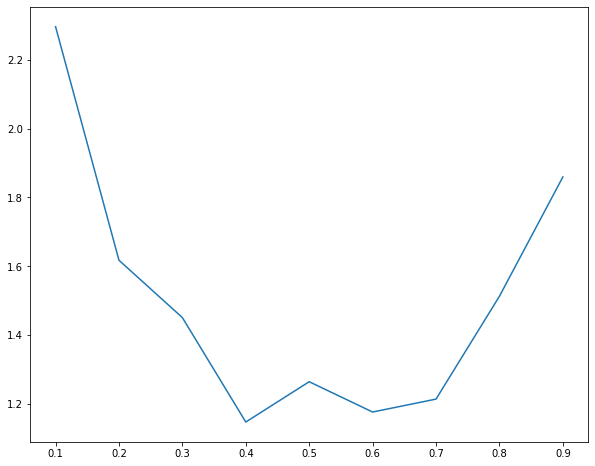

In [258]:
from statsmodels.regression.quantile_regression import QuantReg


reg_df = df1[df1.year.isin([2016, 2017])].dropna()


quant = QuantReg(reg_df[['ln_house_dispose_income']], reg_df[['ln_min_wage', 'gender', 'arab', 'constant']])
quantiles = [x/100 for x in list(range(10, 100, 10))]

def fit_model(q):
    res = quant.fit(q=q)
    return [q,  res.params['ln_min_wage']]
            

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'ln_min_wage'])
plt.figure(figsize=(10, 8))
plt.plot(models.q, models.ln_min_wage)

In [259]:
mod = QuantReg(reg_df[['ln_house_dispose_income']], reg_df[x_cols])\
        .fit(q=0.1)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            QuantReg Regression Results                            
===================================================================================
Dep. Variable:     ln_house_dispose_income   Pseudo R-squared:               0.2414
Model:                            QuantReg   Bandwidth:                     0.08705
Method:                      Least Squares   Sparsity:                        2.858
Date:                     Sat, 20 Jun 2020   No. Observations:                 7894
Time:                             19:39:36   Df Residuals:                     7880
                                             Df Model:                           14
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
min_wage       0.0004   5.64e-05      6.755      0.000       0.000       0.000
age            0.1104      0.012      9.580      0.000       0.088       0.133
age_sq        -0.0012      0.000     -8.427      0.000      -0.002      -0.001
gender         0.0319      0.021      1.551      0.121      -0.008       0.072
rusia         -0.0609      0.029     -2.071      0.038      -0.119      -0.003
educ_years     0.1608      0.011     15.044      0.000       0.140       0.182
educ_sq       -0.0041      0.000    -10.745      0.000      -0.005      -0.003
people        -0.0151      0.009     -1.648      0.099      -0.033       0.003
rooms          0.1425      0.010     13.589      0.000       0.122       0.163
arab          -0.2666      0.018    -14.442      0.000      -0.303      -0.230
single         2.5382      0.198     12.844      0.000       2.151       2.926
married        3.1167      0.199     15.691      0.000       2.727       3.506
divorced       2.5506      0.200     12.726      0.000       2.158       2.944
widow          2.8201      0.222     12.731      0.000       2.386       3.254
==============================================================================

The condition number is large, 3.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [260]:
mod = QuantReg(reg_df[['ln_house_dispose_income']], reg_df[x_cols])\
        .fit(q=0.5)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            QuantReg Regression Results                            
===================================================================================
Dep. Variable:     ln_house_dispose_income   Pseudo R-squared:               0.2283
Model:                            QuantReg   Bandwidth:                      0.1050
Method:                      Least Squares   Sparsity:                        1.066
Date:                     Sat, 20 Jun 2020   No. Observations:                 7894
Time:                             19:39:36   Df Residuals:                     7880
                                             Df Model:                           14
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
min_wage       0.0005   4.39e-05     11.197      0.000       0.000       0.001
age            0.0472      0.007      7.187      0.000       0.034       0.060
age_sq        -0.0005   8.34e-05     -5.430      0.000      -0.001      -0.000
gender         0.0129      0.013      0.970      0.332      -0.013       0.039
rusia         -0.0358      0.018     -1.970      0.049      -0.071      -0.000
educ_years     0.1062      0.009     12.263      0.000       0.089       0.123
educ_sq       -0.0021      0.000     -7.489      0.000      -0.003      -0.002
people        -0.0141      0.005     -2.914      0.004      -0.024      -0.005
rooms          0.1442      0.006     24.799      0.000       0.133       0.156
arab          -0.1706      0.013    -13.638      0.000      -0.195      -0.146
single         4.3544      0.200     21.756      0.000       3.962       4.747
married        4.7015      0.200     23.523      0.000       4.310       5.093
divorced       4.2208      0.201     21.005      0.000       3.827       4.615
widow          4.3166      0.209     20.681      0.000       3.907       4.726
==============================================================================

The condition number is large, 3.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Average of quantiles

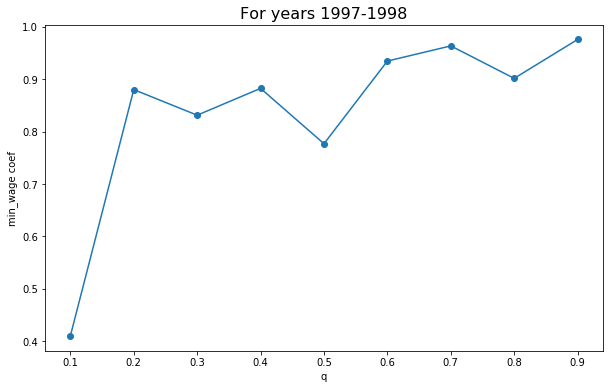

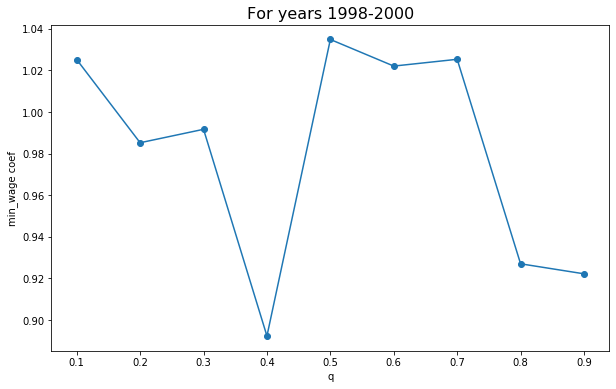

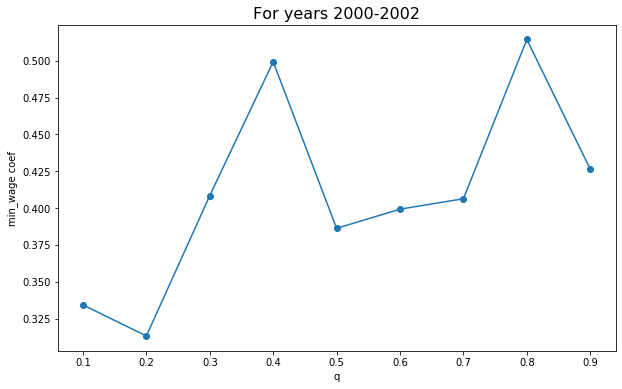

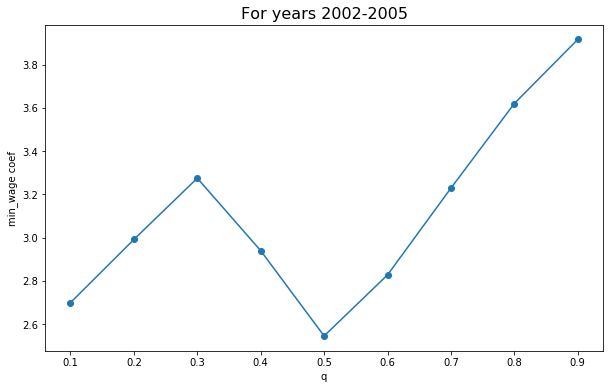

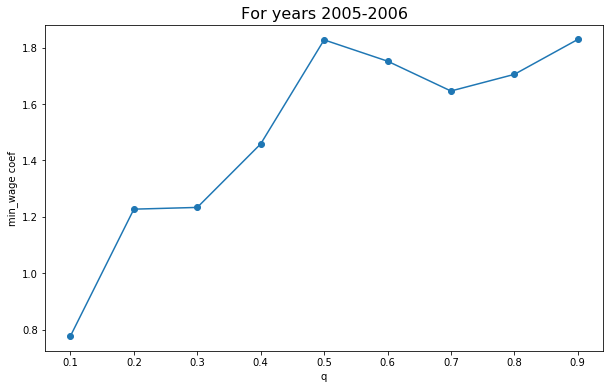

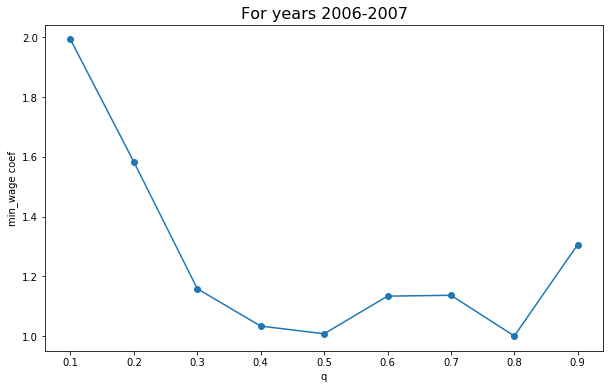

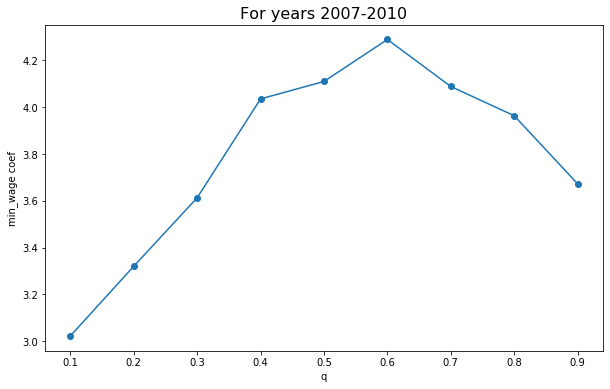

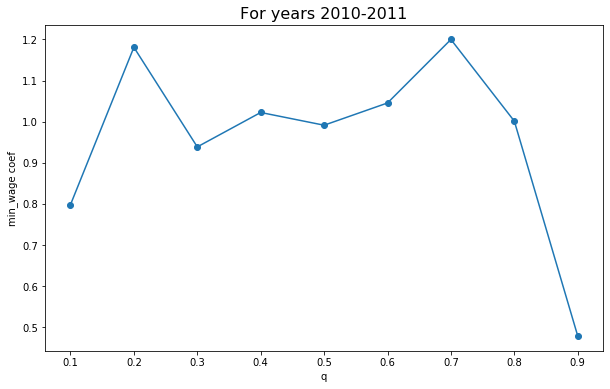

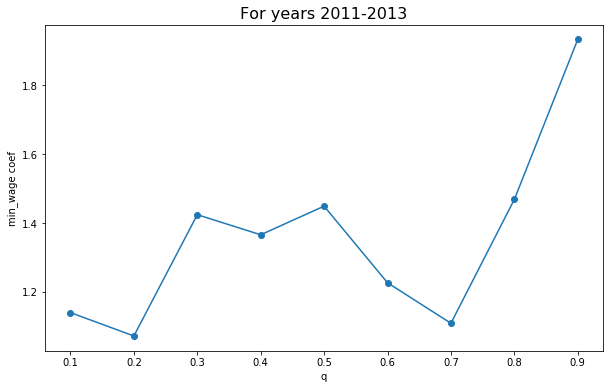

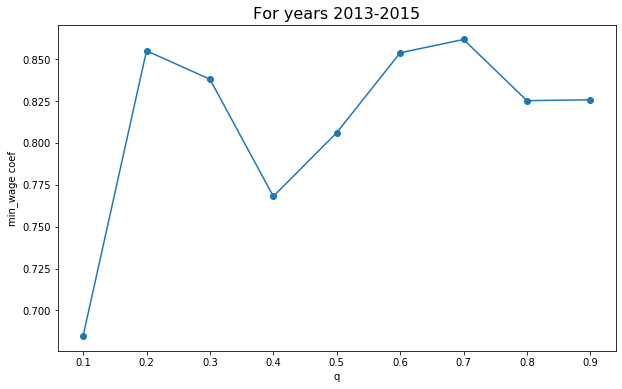

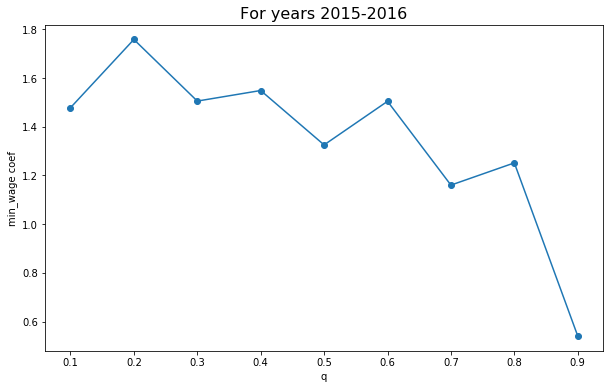

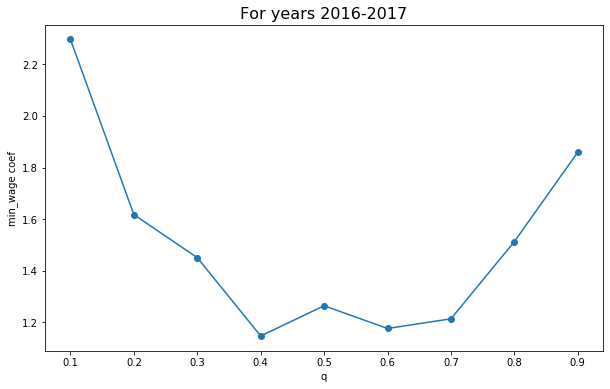

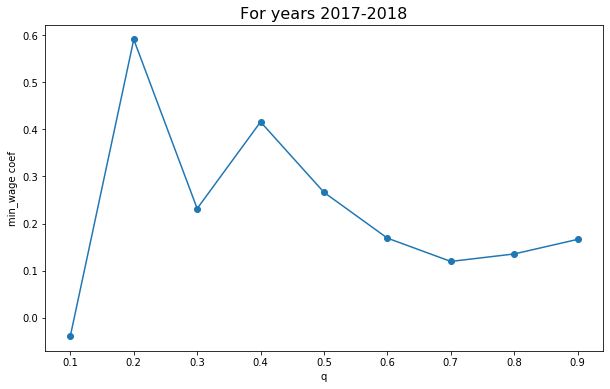

,year,q,ln_min_wage_coef
0,1998,0.10,0.41
1,1998,0.20,0.88
2,1998,0.30,0.83
3,1998,0.40,0.88
4,1998,0.50,0.78
5,1998,0.60,0.93
6,1998,0.70,0.96
7,1998,0.80,0.90
8,1998,0.90,0.98
9,2000,0.10,1.03


In [261]:
years = df1.year.value_counts().sort_index().index.to_list()
years.remove(2001)
years.remove(2004)
years.remove(2009)
years.remove(2012)
years.remove(2014)


quantiles = np.arange(.1, 1, .1)
models = []
min_wage_coef_lst = []

x_cols = ['ln_min_wage', 'age', 'age_sq', 'gender',
        'rusia', 'educ_years', 'educ_sq', 'people', 'rooms', 'arab', 'single', 'married',
        'divorced', 'constant']

x_cols = ['ln_min_wage', 'gender', 'arab', 'constant']

for i in range((len(years)-1)):
    min_wage_coef_lst = []
    quant_df = df1[df1.year.isin([years[i], years[i+1]])]
    quant_df = sm.add_constant(quant_df)
    for q in quantiles:
        mod = QuantReg(quant_df[['ln_house_dispose_income']], quant_df[x_cols])\
        .fit(q=q)
        models.append([years[i+1], q, mod.params['ln_min_wage']])
        min_wage_coef_lst.append(mod.params['ln_min_wage'])
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(quantiles, min_wage_coef_lst, '-o')
    ax.set_xlabel('q', fontsize=10)
    ax.set_ylabel('min_wage coef', fontsize=10)
    plt.title('For years {}-{}'.format(years[i], years[i+1]), fontsize=16)
    plt.show()
    
    
models = pd.DataFrame(models, columns=['year', 'q', 'ln_min_wage_coef'])

models.head(10)

In [246]:
quantiles = [0.1, 0.5]
for i in range((len(years)-1)):
    print("\n\n\n\n\n\n\n\n\nYear is: {}".format(years[i]))
    min_wage_coef_lst = []
    quant_df = df1[df1.year.isin([years[i], years[i+1]])]
    quant_df = sm.add_constant(quant_df)
    for q in quantiles:
        print("\n\n\nq is: {}".format(q))
        mod = QuantReg(quant_df[['ln_house_dispose_income']], quant_df[x_cols])\
        .fit(q=q)
        print(mod.summary())










Year is: 1997



q is: 0.1
                            QuantReg Regression Results                            
Dep. Variable:     ln_house_dispose_income   Pseudo R-squared:              0.04297
Model:                            QuantReg   Bandwidth:                     0.09122
Method:                      Least Squares   Sparsity:                        3.043
Date:                     Sat, 20 Jun 2020   No. Observations:                12449
Time:                             19:38:34   Df Residuals:                    12445
                                             Df Model:                            3
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ln_min_wage     0.4101      0.190      2.162      0.031       0.038       0.782
gender         -0.3137      0.020    -15.822      0.000      -0.353      -0.275
arab           -0.3223      0.024    -13.184      0.000 

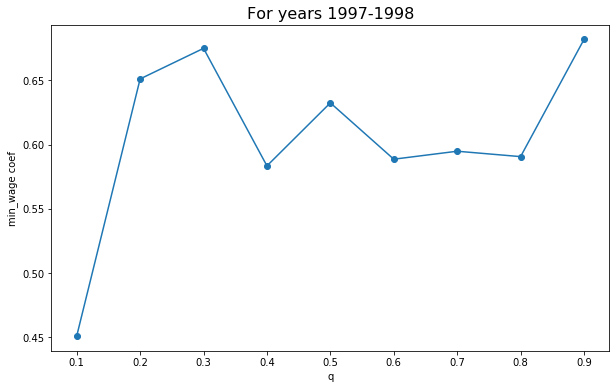

/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


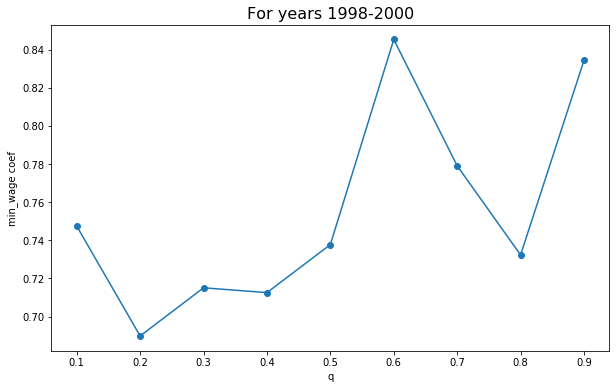

/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


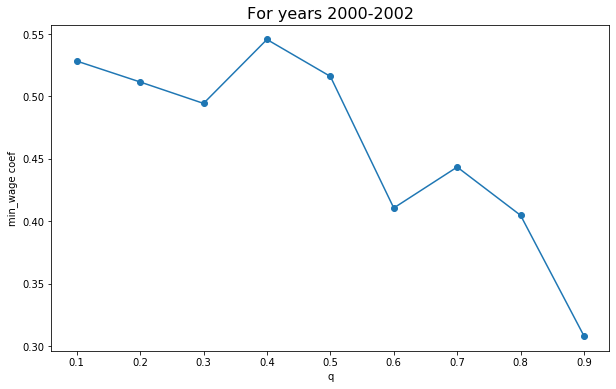

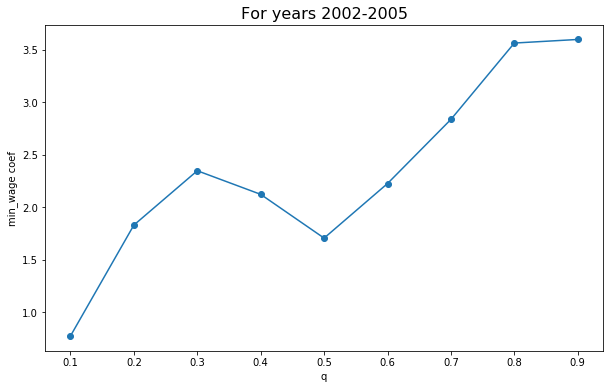

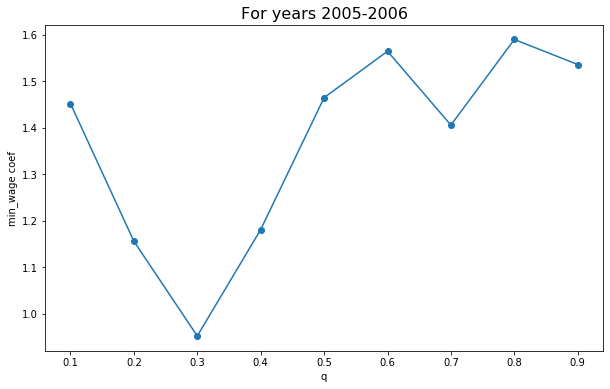

/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


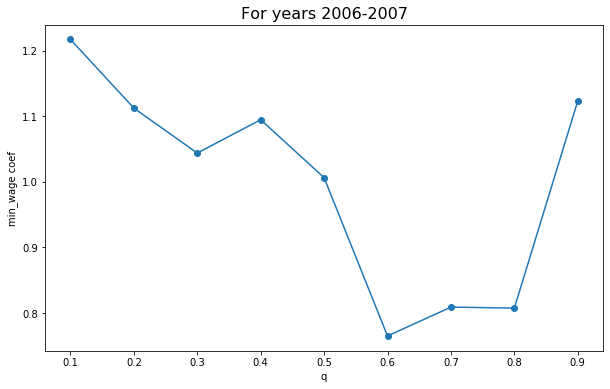

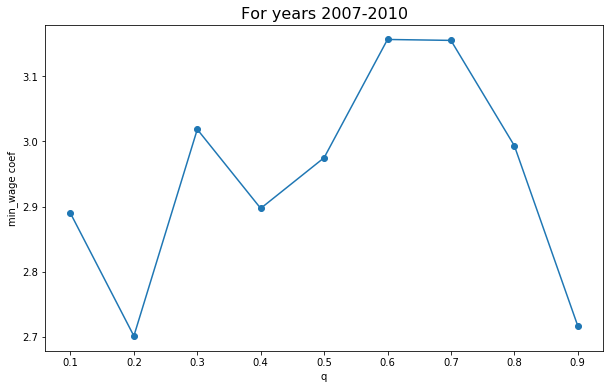

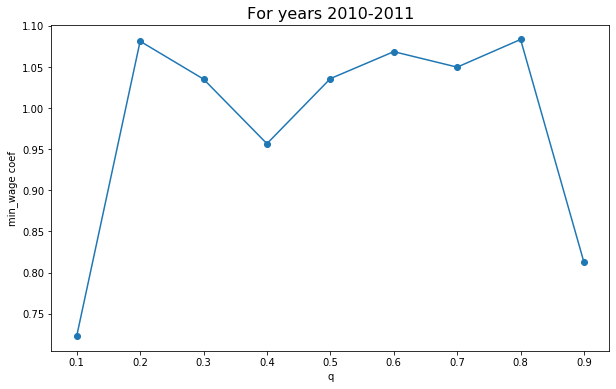

/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


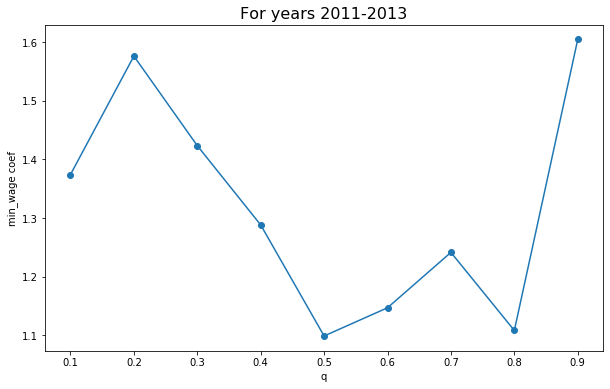

/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


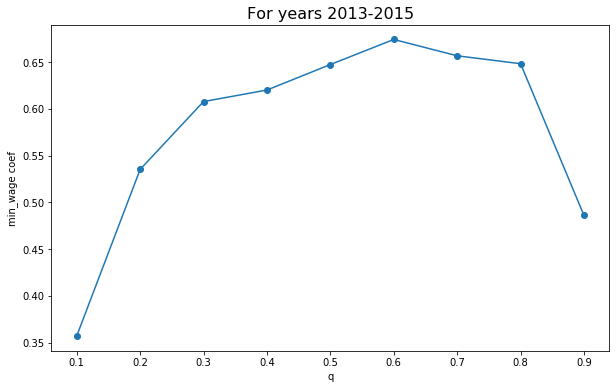

/Users/eyalmichaeli/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


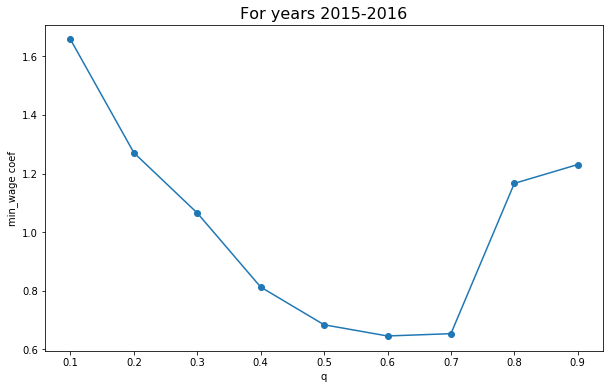

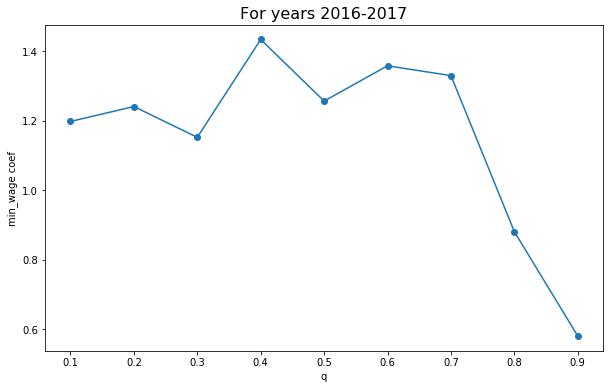

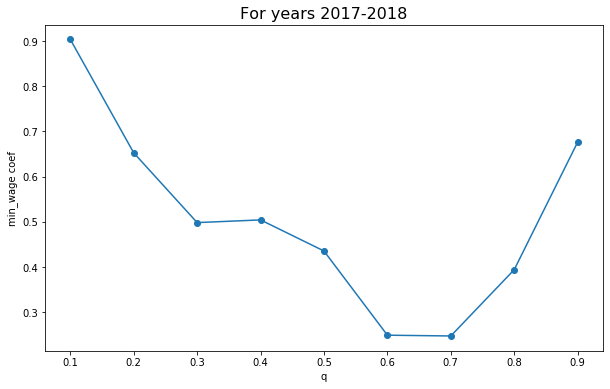

In [247]:
years = df1.year.value_counts().sort_index().index.to_list()
years.remove(2001)
years.remove(2004)
years.remove(2009)
years.remove(2012)
years.remove(2014)


quantiles = np.arange(.1, 1, .1)
models = []
min_wage_coef_lst = []
x_cols = ['ln_min_wage', 'age', 'age_sq', 'gender',
        'rusia', 'educ_years', 'educ_sq', 'people', 'rooms', 'arab', 'single', 'married',
        'divorced', 'constant']


for i in range((len(years)-1)):
    min_wage_coef_lst = []
    quant_df = df1[df1.year.isin([years[i], years[i+1]])]
    quant_df = sm.add_constant(quant_df)
    for q in quantiles:
        mod = QuantReg(quant_df[['ln_house_dispose_income']], quant_df[x_cols])\
        .fit(q=q)
        models.append([years[i+1], q, mod.params['ln_min_wage']])
        min_wage_coef_lst.append(mod.params['ln_min_wage'])
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(quantiles, min_wage_coef_lst, '-o')
    ax.set_xlabel('q', fontsize=10)
    ax.set_ylabel('min_wage coef', fontsize=10)
    plt.title('For years {}-{}'.format(years[i], years[i+1]), fontsize=16)
    plt.show()


    
models = pd.DataFrame(models, columns=['year', 'q', 'ln_min_wage_coef'])


In [ ]:
#models.head(100)

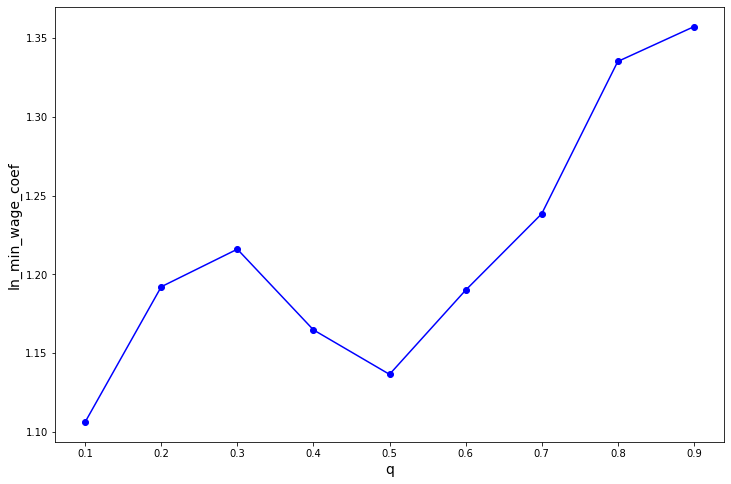

In [143]:
temp = models.groupby('q').mean().drop(columns = ['year'])

fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(temp.index, temp.ln_min_wage_coef.values, '-o', color = 'blue')
ax.set_xlabel("q", fontsize=14)
ax.set_ylabel('ln_min_wage_coef', fontsize=14)
plt.show()

# More analysis

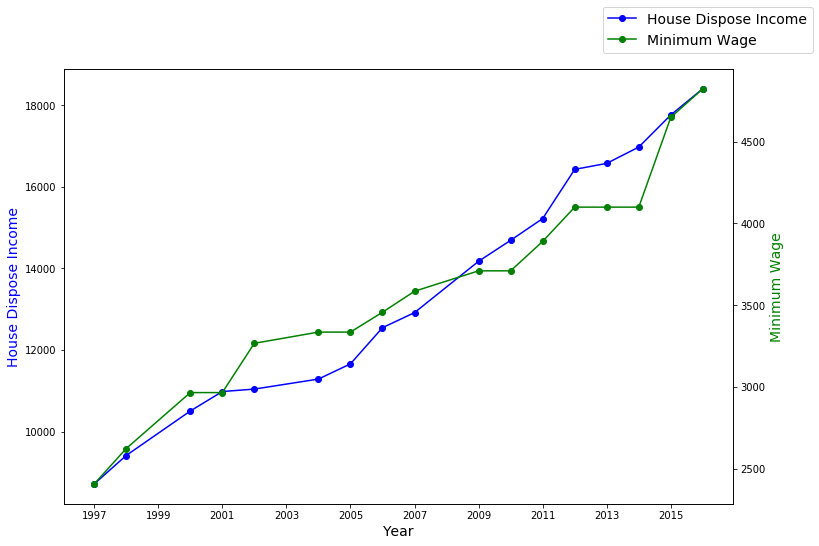

In [144]:
temp = df1.groupby(['year']).mean()

fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(temp.index, temp.house_dispose_income.values, '-o', color = 'blue', label = 'House Dispose Income')
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel('House Dispose Income', fontsize=14, c = 'b')
ax2=ax.twinx()
ax2.plot(temp.index, temp.min_wage.values, '-o', color = 'green', label = 'Minimum Wage')
ax2.set_ylabel('Minimum Wage', fontsize=14, c = 'g')
ax.set_xticks(range(1997, 2017, 2))
ax.figure.legend(fontsize=14)
plt.show()

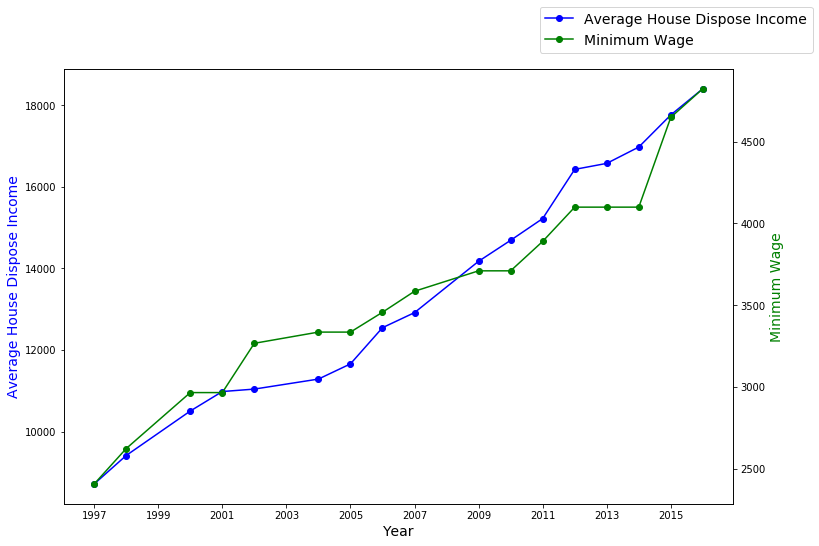

In [147]:
temp = df1.groupby(['year']).mean()

fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(temp.index, temp.house_dispose_income.values, '-o', color = 'blue', label = 'Average House Dispose Income')
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel('Average House Dispose Income', fontsize=14, c = 'b')
ax2=ax.twinx()
ax2.plot(temp.index, temp.min_wage.values, '-o', color = 'green', label = 'Minimum Wage')
ax2.set_ylabel('Minimum Wage', fontsize=14, c = 'g')
ax.set_xticks(range(1997, 2017, 2))
ax.figure.legend(fontsize=14)
plt.show()

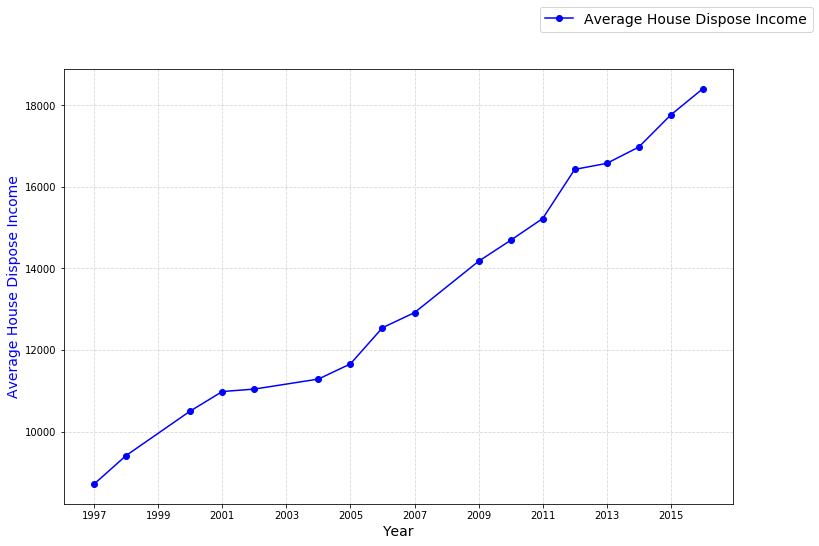

In [266]:

fig, ax = plt.subplots(figsize = (12, 8))
ax.grid(alpha=0.5, linestyle='dashed')
ax.plot(temp.index, temp.house_dispose_income.values, '-o', color = 'blue', label = 'Average House Dispose Income')
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel('Average House Dispose Income', fontsize=14, c = 'b')
ax.set_xticks(range(1997, 2017, 2))
ax.figure.legend(fontsize=14)
plt.show()

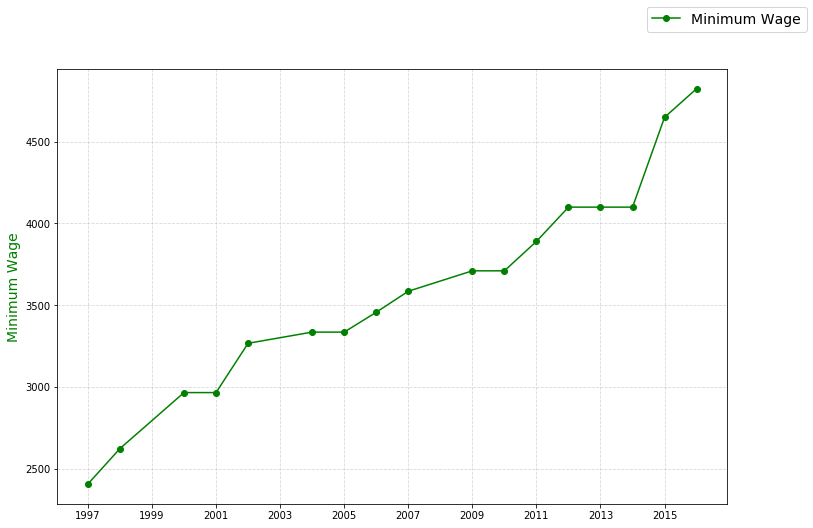

In [268]:
fig, ax2 = plt.subplots(figsize = (12, 8))
ax2.grid(alpha=0.5, linestyle='dashed')
ax2.plot(temp.index, temp.min_wage.values, '-o', color = 'green', label = 'Minimum Wage')
ax2.set_ylabel('Minimum Wage', fontsize=14, c = 'g')
ax2.set_xticks(range(1997, 2017, 2))
ax2.figure.legend(fontsize=14)
plt.show()